# Data Dictionary

|Attribute|Description
----------|-----------
InvoiceNo| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode| Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description| Product (item) name. Nominal.
Quantity| The quantities of each product (item) per transaction. Numeric.
InvoiceDate| Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice| Unit price. Numeric, Product price per unit in sterling.
CustomerID| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country| Country name. Nominal, the name of the country where each customer resides.

# 0.0 Imports

In [1]:
import pandas as pd
import inflection
from src import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np
import scipy.stats as st
from scipy.stats import kstest
import sweetviz

import dotenv
import datetime as dt

import umap.umap_ as um
from sklearn.decomposition import PCA
import sklearn.metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.manifold as man

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
import sklearn.mixture as mix
from scipy.cluster.hierarchy import dendrogram, ward, linkage, fcluster
import pickle
import s3fs

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Feature Engineering Functions

In [2]:
def recency_feat(df_feature_, df_feature_transaction_):

    # Recency
    diff = df_feature_.invoice_date.max() - df_feature_transaction_.groupby('customer_id').max()['invoice_date']
    recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

    recency['recency'] = recency['recency'].dt.days

    return recency
    df_feature_ = df_feature_.merge((recency), how='left', on='customer_id')

def frequency_feat(df_feature_, df_feature_transaction_):
    # Frequency
    min_date = df_feature_.invoice_date.min()
    max_date = df_feature_.invoice_date.max()
    aux = df_feature_transaction_.groupby('customer_id').agg( max_ = ('invoice_date', 'max'), 
                                        min_ = ('invoice_date', 'min'),
                                        #days_ = ('invoice_date', lambda x: (max_date - min_date).days + 1),
                                        days_ = ('invoice_date', lambda x: (max_date - x.min()).days + 1),
                                        buy_ = ('invoice_no', 'nunique'),
                                        ).reset_index()

    aux['frequency'] = aux.buy_/aux.days_

    return aux

    df_feature_ = df_feature_.merge(aux[['customer_id', 'frequency']], on='customer_id', how='left')

def total_spent_feat(df_feature_, df_feature_transaction_):

    # Total Spent
    df_feature_['gross_revenue'] = df_feature_.quantity * df_feature_.unit_price

    monetary = df_feature_.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'total_spent'})
    df_feature_ = df_feature_.merge((monetary), how='left', on='customer_id')

    return monetary

In [3]:
def transactions_feat(df_features_):

    # Transactions
    transactions = df_features_.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'transactions'})

    return transactions

def avg_ticket_feat(df_features_):

    # Average Ticket
    avg_ticket = df_features_.groupby(['customer_id', 'invoice_no']).sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'avg_ticket'}).groupby('customer_id').mean(numeric_only=True).reset_index()
   
    return avg_ticket

def product_variety_feat(df_features_):

    # Product Variety
    product_variety = df_features_.groupby('customer_id').nunique()[['description']].reset_index().rename(columns={'description': 'product_variety'})
    
    return product_variety

def avg_basket_feat(df_features_):

    # Average Basket Size 
    avg_basket = df_features_[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).sum()\
                                                                                                                    .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                    .reset_index().rename(columns={'quantity': 'avg_basket'})

    return avg_basket

def avg_basket_variety_feat(df_features_): 

    # Average Basket Variety Size
    avg_basket_var = df_features_[['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id', 'invoice_no']).nunique()\
                                                                                                                    .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                    .reset_index().rename(columns={'stock_code': 'avg_basket_variety'})
  
    return avg_basket_var

In [4]:
def cancellations_feat(df_features_): 

    cancellations = df_features_[['customer_id', 'quantity']].groupby('customer_id').apply(lambda c: c.abs().sum())[['quantity']].reset_index().rename(columns={'quantity': 'number_of_cancellations'})

    return cancellations

def quantity_feat(df_features_): 

    # Total Quantity
    quantity = df_features_.groupby('customer_id').sum(numeric_only=True).quantity.reset_index().rename(columns={'quantity': 'total_quantity'})

    return quantity

In [55]:
plt.style.use('ggplot')
#sns.set_style('darkgrid')

# 0.1 Load Data

In [6]:
secret = dotenv.dotenv_values('../.env')['SECRET_KEY']
key = dotenv.dotenv_values('../.env')['ACCESS_KEY']

path_s3 = 's3://insider-data-bucket/'
df_raw = pd.read_csv(path_s3 +  'Ecommerce.csv', 
                     encoding='ISO-8859-1',
                     storage_options={'key': key,
                                      'secret': secret})
#df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [7]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  Unnamed: 8  
0   29-Nov-16       2.55     17850.0  United Kingdom         NaN  
1   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
2   29-Nov-16       2.75     17850.0  United Kingdom         NaN  
3   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
4   29-Nov-16       3.39     17850.0  United Kingdom         NaN

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 1.0. Data Description

In [8]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [9]:
df_description.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1. Renaming Columns

In [10]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [11]:
df_description['description'] = df_description['description'].str.lower()

In [12]:
df_description.sort_values(['invoice_date', 'description'])

invoice_no stock_code                       description  quantity  \
143414     548701      23007            spaceboy baby gift set         1   
143694     548711      22906   12 message cards with envelopes         2   
144000     548715      22906   12 message cards with envelopes         6   
143573     548708      84461      12 pink hen+chicks in basket         1   
144035     548715      21457  2 picture book eggs easter ducks         6   
...           ...        ...                               ...       ...   
335644     566290      84836       zinc metal heart decoration         2   
335748     566291      84836       zinc metal heart decoration         3   
335588     566290      23153  zinc sweetheart wire letter rack         2   
334150     566233      23145    zinc t-light holder star large        12   
334151     566233      23144   zinc t-light holder stars small        12   

       invoice_date  unit_price  customer_id         country  
143414     1-Apr-17       16.95      17629.0  United Kingdom  
143694     1-Apr-17        1.65      18116.0  United Kingdom  
144000     1-Apr-17        1.65      17758.0  United Kingdom  
143573     1-Apr-17        2.55      13269.0  United Kingdom  
144035     1-Apr-17        1.25      17758.0  United Kingdom  
...             ...         ...          ...             ...  
335644     9-Sep-17        1.25      14456.0  United Kingdom  
335748     9-Sep-17        1.25      12965.0  United Kingdom  
335588     9-Sep-17        3.75      14456.0  United Kingdom  
334150     9-Sep-17        0.95      12635.0         Germany  
334151     9-Sep-17        0.83      12635.0         Germany  

[541909 rows x 8 columns]

## 1.2. Data Dimension

In [13]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [14]:
gu.sum_table(df_description)

Name   dtypes  Uniques  Missing  Missing %
0    invoice_no   object    25900        0       0.00
1    stock_code   object     4070        0       0.00
2   description   object     4206     1454       0.27
3      quantity    int64      722        0       0.00
4  invoice_date   object      305        0       0.00
5    unit_price  float64     1630        0       0.00
6   customer_id  float64     4372   135080      24.93
7       country   object       38        0       0.00

## 1.4.  Handling Missing Values

Checking if there are invoice numbers of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [15]:
df_missing = df_description.query('customer_id.isnull()')
df_no_missing = df_description.query('~customer_id.isnull()')

inv_no_missing_customers = df_missing.invoice_no.unique()
stock_code_missing_customers = df_no_missing.stock_code.unique()

df_description.loc[df_description.invoice_date.isin(inv_no_missing_customers)]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

**I will assign a custom customer ID to each unique invoice number with a missing customer ID. A unique custom customer ID will be assigned for each unique invoice number.**

Issue: by doing this, these new customers' IDs will only have one transaction, but this might be better than removing all this data.

In [16]:
missing_invoice_no = df_missing[['invoice_no']].drop_duplicates()
missing_invoice_no['customer_id'] = np.arange(19000, 19000+len(missing_invoice_no))
df_description = df_description.merge(missing_invoice_no, on='invoice_no', how='left')
df_description['customer_id'] = df_description['customer_id_x'].combine_first(df_description['customer_id_y'])
df_clean = df_description.drop(columns=['customer_id_x', 'customer_id_y'])

## 1.5. Fixing Data Types

In [17]:
df_clean.invoice_date = pd.to_datetime(df_clean.invoice_date)
df_clean.customer_id = df_clean.customer_id.astype(int)

In [18]:
df_clean.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.6. Descriptive Statistics

### 1.6.1 Numerical Attributes

In [19]:
num_att = df_clean.select_dtypes(include=['float64', 'int64'])
cat_att = df_clean.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [20]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

Attributes       min      max      range      mean  median           var  \
0    quantity -80995.00  80995.0  161990.00  9.552250    3.00  47559.391409   
1  unit_price -11062.06  38970.0   50032.06  4.611114    2.08   9362.469164   

          std        skew       kurtosis  
0  218.081158   -0.264076  119769.160031  
1   96.759853  186.506972   59005.719097

In [21]:
df_clean.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997])[['quantity', 'unit_price']].T

count      mean         std       min    1%    5%   10%   20%  \
quantity    541909.0  9.552250  218.081158 -80995.00 -2.00  1.00  1.00  1.00   
unit_price  541909.0  4.611114   96.759853 -11062.06  0.19  0.42  0.63  0.85   

             50%    80%    90%    95%    99%   99.7%      max  
quantity    3.00  12.00  24.00  29.00  100.0  240.00  80995.0  
unit_price  2.08   4.95   7.95   9.95   18.0   39.95  38970.0

In [22]:
df_clean.sort_values('quantity').head()

invoice_no stock_code                          description  quantity  \
540422    C581484      23843          paper craft , little birdie    -80995   
61624     C541433      23166       medium ceramic top storage jar    -74215   
225529     556690      23005         printing smudges/thrown away     -9600   
225530     556691      23005         printing smudges/thrown away     -9600   
4287      C536757      84347  rotating silver angels t-light hldr     -9360   

       invoice_date  unit_price         country  customer_id  
540422   2017-12-07        2.08  United Kingdom        16446  
61624    2017-01-16        1.04  United Kingdom        12346  
225529   2017-06-12        0.00  United Kingdom        20914  
225530   2017-06-12        0.00  United Kingdom        20915  
4287     2016-11-30        0.03  United Kingdom        15838

There are some weird values in this dataset. We know that 'C' stands for cancellation in the invoice code, so we expect to see a negative quantity in these instances. But we can observe some samples that aren't cancellations with a negative quantity. We will further examine this issue the filter variables section.

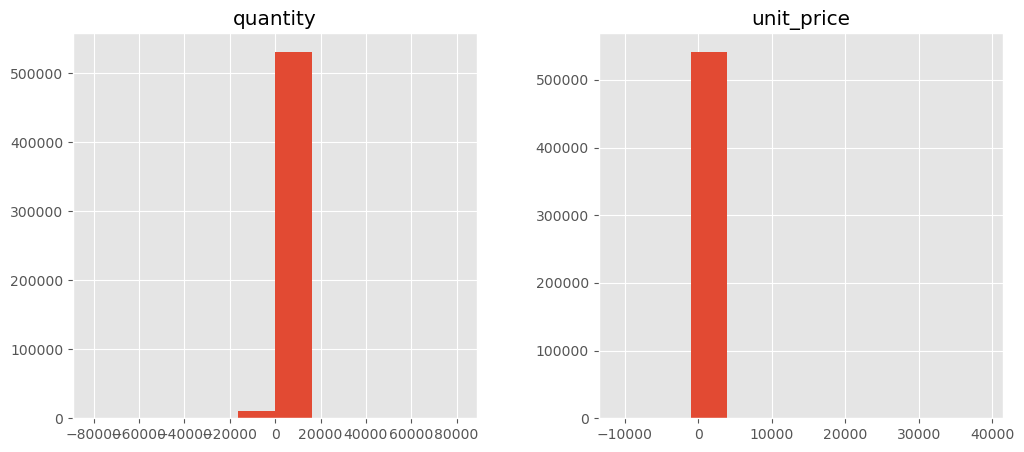

In [23]:
df_clean.drop(columns=['invoice_date', 'customer_id']).hist(figsize=(12, 5));

### <font color='red'> 1.6.2  Further Analysis needed </font>

Quantity with negative values -> What to do with cancellations.

Unit price < 0 -> error? remove these values?

Unit Price very close to 0?

### 1.6.3 Categorical Attributes

**Invoice Number with at least one string**

In [24]:
# df_description.inoice_no.astype(int)
letter_invoices = df_clean.loc[df_description.invoice_no.str.contains('C')]

print('Total Number of Cancellation invoices:', len(letter_invoices))
print('Total Number of Negative quantites:', len(letter_invoices.query('quantity < 0')))

Total Number of Cancellation invoices: 9288
Total Number of Negative quantites: 9288


**Stock codes with at least one string**

In [25]:
df_clean.loc[~df_clean.stock_code.str.isdigit()].head()

invoice_no stock_code                          description  quantity  \
0      536365     85123A   white hanging heart t-light holder         6   
2      536365     84406B       cream cupid hearts coat hanger         8   
3      536365     84029G  knitted union flag hot water bottle         6   
4      536365     84029E       red woolly hottie white heart.         6   
45     536370       POST                              postage         3   

   invoice_date  unit_price         country  customer_id  
0    2016-11-29        2.55  United Kingdom        17850  
2    2016-11-29        2.75  United Kingdom        17850  
3    2016-11-29        3.39  United Kingdom        17850  
4    2016-11-29        3.39  United Kingdom        17850  
45   2016-11-29       18.00          France        12583

**Stock codes that are only strings**

In [26]:
df_clean.loc[df_clean.stock_code.str.isalpha()].stock_code.value_counts()
# Remove stovk_code in [POST, M, D, DOT, CRUK, PADS, AMAZONFEE ,CRUK, DCGSSGIRL, DCGSSBOY, PADS, B, m]

POST         1256
DOT           710
M             571
D              77
S              63
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: stock_code, dtype: int64

**Countries**

In [27]:
df_clean.groupby('country').nunique()[['customer_id']].reset_index().sort_values('customer_id', ascending=False)

country  customer_id
36        United Kingdom         7587
14               Germany           95
13                France           90
10                  EIRE           44
31                 Spain           31
3                Belgium           25
33           Switzerland           24
27              Portugal           20
19                 Italy           15
16             Hong Kong           15
12               Finland           12
1                Austria           11
25                Norway           10
24           Netherlands            9
0              Australia            9
37           Unspecified            9
9                Denmark            9
6        Channel Islands            9
7                 Cyprus            8
32                Sweden            8
20                 Japan            8
18                Israel            7
26                Poland            6
5                 Canada            4
34                   USA            4
2                Bahrain            4
15                Greece            4
23                 Malta            2
35  United Arab Emirates            2
8         Czech Republic            1
22             Lithuania            1
11    European Community            1
21               Lebanon            1
28                   RSA            1
29          Saudi Arabia            1
30             Singapore            1
17               Iceland            1
4                 Brazil            1

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 2.0. Variables Filtering

In [28]:
df_filter = df_clean.copy()
columns = ['invoice_no', 'quantity', 'invoice_date', 'unit_price', 'customer_id']

## 2.1. Numerical

In [29]:
df_filter.query("(quantity <= 0 & invoice_no.str.isdigit())").sort_values('quantity').description.unique()[:40]#.head()

array(['printing smudges/thrown away', 'throw away',
       'unsaleable, destroyed.', nan, 'wrongly marked. 23343 in box',
       'check', 'incorrect stock entry.', 'mouldy, thrown away.',
       "thrown away-can't sell", 'thrown away-rusty', '?missing',
       'mouldy, unsaleable.', 'damages wax', 'damages/credits from asos.',
       'mystery! only ever imported 1800', 'damaged', 'thrown away',
       'given away', 'incorrectly credited c550456 see 47',
       'reverse previous adjustment', 'sold as set on dotcom and amazon',
       '? sold as sets?', 'lost??', 'thrown away.', 'damaged stock', '?',
       'lost', 'wrongly coded 20713', 'damages', 'wrongly sold sets',
       'code mix up? 84930', 'wet rusty', 'missing',
       'wrongly coded-23343', 'sold as set/6 by dotcom',
       'possible damages or lost?', 'wet pallet', 'sold in set?',
       'dotcom set', '??'], dtype=object)

By the description of those items, it seems like they are some mistakes or an issue with the product. Since these instances don't represent actual sales, we will remove them from the dataset.

In [30]:
df_filter = df_filter.query("~(quantity <= 0 & invoice_no.str.isdigit())")

**Unit prices very close to zero**

In [31]:
df_filter.query('unit_price >= 0 and unit_price < 0.004').sort_values('unit_price').isnull().sum()

invoice_no        0
stock_code        0
description     592
quantity          0
invoice_date      0
unit_price        0
country           0
customer_id       0
dtype: int64

Half of the instances don't have a description, which makes it harder to define what these instances mean. Therefore, they will be removed (unit price < 0.004).

In [32]:
df_filter = df_filter.query('unit_price >= 0.004')

## 2.2. Categorical

In [33]:
# removing stock_codes that are only letters
df_filter = df_filter.query("~stock_code.isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])")

# removing European Community and Unspecified
df_filter = df_filter.query("~country.isin(['European Community', 'Unspecified'])")

#country_dict = {'EIRE': 'Ireland', 'RSA': 'South Africa', 'USA': 'United States', 'Channel Islands': 'United Kingdom'}

#countries_to_modify = ['USA', 'Channel Islands', 'RSA', 'EIRE']

#df_filter.country = df_filter.country.apply(lambda x: country_dict[x] if x in countries_to_modify else x)

In [34]:
# description
print(f'Removed data: {1 - (df_filter.shape[0]/df_clean.shape[0]):.3%}')
print(f'Number of Elements Removed: {df_clean.shape[0] - df_filter.shape[0]}')

Removed data: 1.064%
Number of Elements Removed: 5765


In [35]:
df_filter.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

In [36]:
print('Number of rows Cancelation:', df_filter.query("quantity < 0 or invoice_no.str.contains('C')").shape[0])
print('Number of rows Transaction:', df_filter.query('quantity > 0').shape[0])

Number of rows Cancelation: 8730
Number of rows Transaction: 527414


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 3.0. Feature Engineering

In [37]:
df_feature = df_filter.copy()
df_feature_cancellation = df_filter.query("quantity < 0 or invoice_no.str.contains('C')").copy()
df_feature_transaction = df_filter.query('quantity > 0').copy()

**Recency, Frequency and Monetary**

In [38]:
#  Number of days since the last purchase
recency = recency_feat(df_feature, df_feature_transaction)

# Number of unique purchases/days since first date in the dataset.
frequency = frequency_feat(df_feature, df_feature_transaction)

# Total Spent
monetary = total_spent_feat(df_feature, df_feature_transaction)

**Number of transactions, Variety, Average Ticket and Average Basket Size**

In [39]:
# Number of purchases
transactions = transactions_feat(df_feature)

# Average purchases value
avg_ticket = avg_ticket_feat(df_feature)

# Number Unique products.
product_variety = product_variety_feat(df_feature_transaction)

# Average basket size
avg_basket = avg_basket_feat(df_feature)

# Average number of unique products per purchase
avg_basket_variety = avg_basket_variety_feat(df_feature_transaction)

**Average Recency, Total Cancelltions, Quantity** - <font color='red'>Average Recency Removed</font>

In [41]:
# Number of cancellation
cancellations = cancellations_feat(df_feature_cancellation)

# Total Quantity
quantity = quantity_feat(df_feature)

In [42]:
df_feature_new = df_feature.copy().merge(recency, how='left', on='customer_id')\
.drop_duplicates('customer_id')\
.merge(frequency[['customer_id', 'frequency']], how='left', on='customer_id')\
.merge(monetary, how='left', on='customer_id')\
.merge(transactions, how='left', on='customer_id')\
.merge(avg_ticket, how='left', on='customer_id')\
.merge(product_variety, how='left', on='customer_id')\
.merge(avg_basket, how='left', on='customer_id')\
.merge(avg_basket_variety, how='left', on='customer_id')\
.merge(cancellations, how='left', on='customer_id')\
.merge(quantity, how='left', on='customer_id')


In [43]:
df_feature_new.isnull().sum()

invoice_no                    0
stock_code                    0
description                   0
quantity                      0
invoice_date                  0
unit_price                    0
country                       0
customer_id                   0
gross_revenue                 0
recency                      91
frequency                    91
total_spent                   0
transactions                  0
avg_ticket                    0
product_variety              91
avg_basket                    0
avg_basket_variety           91
number_of_cancellations    4190
total_quantity                0
dtype: int64

Some customers only have cancellations, they need to be removed.

In [44]:
columns = ['customer_id', 'recency', 'frequency', 'total_spent', 'transactions', 'total_quantity', 'avg_ticket', 'product_variety', 'avg_basket', 'avg_basket_variety', 'number_of_cancellations']
df_customers = df_feature_new.copy()[columns]
df_customers.head()

customer_id  recency  frequency  total_spent  transactions  total_quantity  \
0        17850    372.0   0.090909      5288.63            35            1693   
1        13047     56.0   0.024064      3089.10            16            1355   
2        12583      2.0   0.040107      6629.34            17            4978   
3        13748     95.0   0.013369       948.25             5             439   
4        15100    333.0   0.008021       635.10             6              58   

   avg_ticket  product_variety  avg_basket  avg_basket_variety  \
0  151.103714             21.0   48.371429            8.735294   
1  193.068750            105.0   84.687500           19.000000   
2  389.961176            116.0  292.823529           15.466667   
3  189.650000             24.0   87.800000            5.600000   
4  105.850000              1.0    9.666667            1.000000   

   number_of_cancellations  
0                     40.0  
1                     35.0  
2                     50.0  
3                      NaN  
4                     22.0

In [45]:
df_customers.isnull().sum()

customer_id                   0
recency                      91
frequency                    91
total_spent                   0
transactions                  0
total_quantity                0
avg_ticket                    0
product_variety              91
avg_basket                    0
avg_basket_variety           91
number_of_cancellations    4190
dtype: int64

The number of cancelations with null values are customers with no cancellations.

I want to focus on customers who have made purchases. Therefore I will remove those with a negative monetary value, which may mean they have more canceled orders than purchases.

In [46]:
# fill null values for number of cancellations
df_customers['number_of_cancellations'] = df_customers['number_of_cancellations'].fillna(0)

# removing customers with a total spent <= 0.
df_customers_clean = df_customers.query('(total_spent > 0)')
print('Items Removed:', df_customers.shape[0] - df_customers_clean.shape[0])

Items Removed: 101


In [47]:
df_customers_clean.isnull().sum()

customer_id                0
recency                    0
frequency                  0
total_spent                0
transactions               0
total_quantity             0
avg_ticket                 0
product_variety            0
avg_basket                 0
avg_basket_variety         0
number_of_cancellations    0
dtype: int64

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 4.0. Exploratory Data Analysis

In [48]:
df_eda = df_customers_clean.copy()

## 4.1 Univariate Analysis

In [49]:
import warnings
#warnings.filterwarnings('ignore')

In [101]:
#my_report = sweetviz.analyze(df_eda)
#my_report.show_html(layout='widescreen')

### 4.1.1. Total Spent

In [51]:
df_eda.sort_values('total_spent', ascending=False).head(10)

customer_id  recency  frequency  total_spent  transactions  \
1017        14646      1.0   0.202817    278778.02            73   
492         18102      0.0   0.163043    259657.30            60   
434         17450      8.0   0.125000    189735.53            49   
66          14911      1.0   0.532086    133007.13           243   
1150        12415     24.0   0.059172    123638.18            24   
191         14156      9.0   0.147849    114505.32            65   
15          17511      2.0   0.082888     88138.20            45   
955         16684      4.0   0.077994     65920.12            30   
36          13694      3.0   0.133690     62924.10            57   
8           15311      0.0   0.243316     59419.34           118   

      total_quantity   avg_ticket  product_variety   avg_basket  \
1017          196556  3818.876986            717.0  2692.547945   
492            64124  4327.621667            162.0  1068.733333   
434            69041  3872.153673            125.0  1409.000000   
66             76931   547.354444           1815.0   316.588477   
1150           76946  5151.590833            450.0  3206.083333   
191            57026  1761.620308            730.0   877.323077   
15             63014  1958.626667            465.0  1400.311111   
955            49391  2197.337333            121.0  1646.366667   
36             61808  1103.931579            369.0  1084.350877   
8              37720   503.553729            576.0   319.661017   

      avg_basket_variety  number_of_cancellations  
1017           28.611111                    288.0  
492             7.183333                      0.0  
434             7.304348                    952.0  
66             28.482412                   3332.0  
1150           35.650000                    427.0  
191            25.327273                    859.0  
15             31.064516                   1535.0  
955             9.892857                    864.0  
36             11.360000                   1504.0  
8              25.901099                    474.0

These customers with very high monetary values don't seem to be outliers (errors), just excellent customers.

### 4.1.2. Product Variety

In [52]:
df_eda.sort_values('product_variety', ascending=False).head()

customer_id  recency  frequency  total_spent  transactions  \
66          14911      1.0   0.532086    133007.13           243   
47          12748      0.0   0.550802     30486.53           217   
68          17841      1.0   0.331551     40333.22           169   
4406        14096      4.0   0.166667     53258.43            17   
5266        22221     39.0   0.025000     14855.53             1   

      total_quantity    avg_ticket  product_variety   avg_basket  \
66             76931    547.354444           1815.0   316.588477   
47             23976    140.490922           1776.0   110.488479   
68             22850    238.658107           1344.0   135.207101   
4406           16336   3132.848824           1128.0   960.941176   
5266            5197  14855.530000           1107.0  5197.000000   

      avg_basket_variety  number_of_cancellations  
66             28.482412                   3332.0  
47             20.733010                   1535.0  
68             60.233871                    203.0  
4406          297.882353                      0.0  
5266         1109.000000                      0.0

### 4.1.3. Average Basket

In [53]:
df_eda.sort_values('avg_basket').head(5)

customer_id  recency  frequency   total_spent  transactions  \
4960        12607     60.0   0.016393  3.552714e-15             2   
5026        12454     56.0   0.017544  5.684342e-14             2   
3122        13762    218.0   0.004566  3.552714e-15             2   
5715        12558      7.0   0.125000  1.065814e-14             2   
5409        18274     30.0   0.032258  1.776357e-15             2   

      total_quantity    avg_ticket  product_variety  avg_basket  \
4960               0  0.000000e+00            101.0         0.0   
5026               0  2.273737e-13             15.0         0.0   
3122               0  2.842171e-14              7.0         0.0   
5715               0  0.000000e+00             11.0         0.0   
5409               0  0.000000e+00             11.0         0.0   

      avg_basket_variety  number_of_cancellations  
4960               101.0                   1228.0  
5026                15.0                   1006.0  
3122                 7.0                    272.0  
5715                11.0                    196.0  
5409                11.0                     88.0

In [54]:
df_eda.sort_values('avg_basket', ascending=False).head(5)

customer_id  recency  frequency  total_spent  transactions  \
5369        22312     32.0   0.030303     52940.94             1   
5483        22383     25.0   0.038462     50653.91             1   
4551        18251     87.0   0.011364      4314.72             1   
2639        20055    255.0   0.003906     21389.60             1   
5266        22221     39.0   0.025000     14855.53             1   

      total_quantity  avg_ticket  product_variety  avg_basket  \
5369           14149    52940.94            101.0     14149.0   
5483           13956    50653.91             99.0     13956.0   
4551            7824     4314.72             16.0      7824.0   
2639            5963    21389.60            138.0      5963.0   
5266            5197    14855.53           1107.0      5197.0   

      avg_basket_variety  number_of_cancellations  
5369               101.0                      0.0  
5483                99.0                      0.0  
4551                16.0                      0.0  
2639               138.0                      0.0  
5266              1109.0                      0.0

### 4.1.4. Number of Cancellations

In [56]:
df_eda.sort_values('number_of_cancellations', ascending=False).head(5)

customer_id  recency  frequency  total_spent  transactions  \
3338        16446      0.0   0.009709         2.90             3   
160         15838     11.0   0.051630     33362.28            20   
1262        15749    235.0   0.009009     21535.90             4   
12          16029     38.0   0.165775     58193.85            66   
970         12931     21.0   0.041899     33544.81            19   

      total_quantity   avg_ticket  product_variety   avg_basket  \
3338               2     0.966667              3.0     0.666667   
160             9008  1668.114000             54.0   450.400000   
1262            9014  5383.975000              5.0  2253.500000   
12             32203   881.725000             44.0   487.924242   
970            23577  1765.516316             30.0  1240.894737   

      avg_basket_variety  number_of_cancellations  
3338            1.500000                  80995.0  
160             8.789474                   9360.0  
1262            3.333333                   9014.0  
12              3.854839                   8004.0  
970             5.266667                   4427.0

In [57]:
df_eda.query('number_of_cancellations > 1000 & (transactions < 10 or total_quantity < 1000)')

customer_id  recency  frequency   total_spent  transactions  \
1084        14533     24.0   0.019830  1.812620e+03             9   
1262        15749    235.0   0.009009  2.153590e+04             4   
1722        16938      8.0   0.012945  1.903130e+03             5   
3338        16446      0.0   0.009709  2.900000e+00             3   
4960        12607     60.0   0.016393  3.552714e-15             2   
5026        12454     56.0   0.017544  5.684342e-14             2   

      total_quantity    avg_ticket  product_variety   avg_basket  \
1084            2777  2.014022e+02             53.0   308.555556   
1262            9014  5.383975e+03              5.0  2253.500000   
1722            1025  3.806260e+02            215.0   205.000000   
3338               2  9.666667e-01              3.0     0.666667   
4960               0  0.000000e+00            101.0     0.000000   
5026               0  2.273737e-13             15.0     0.000000   

      avg_basket_variety  number_of_cancellations  
1084            8.857143                   1242.0  
1262            3.333333                   9014.0  
1722           57.750000                   1515.0  
3338            1.500000                  80995.0  
4960          101.000000                   1228.0  
5026           15.000000                   1006.0

I will remove customer 16446 since this is the only one with very few quantities and transactions with an extreme value for the number of cancellations, which indicates that some error occurred.

### 4.1.7 Quantity

In [58]:
df_eda.sort_values('total_quantity', ascending=False).head()

customer_id  recency  frequency  total_spent  transactions  \
1017        14646      1.0   0.202817    278778.02            73   
1150        12415     24.0   0.059172    123638.18            24   
66          14911      1.0   0.532086    133007.13           243   
434         17450      8.0   0.125000    189735.53            49   
492         18102      0.0   0.163043    259657.30            60   

      total_quantity   avg_ticket  product_variety   avg_basket  \
1017          196556  3818.876986            717.0  2692.547945   
1150           76946  5151.590833            450.0  3206.083333   
66             76931   547.354444           1815.0   316.588477   
434            69041  3872.153673            125.0  1409.000000   
492            64124  4327.621667            162.0  1068.733333   

      avg_basket_variety  number_of_cancellations  
1017           28.611111                    288.0  
1150           35.650000                    427.0  
66             28.482412                   3332.0  
434             7.304348                    952.0  
492             7.183333                      0.0

In [59]:
df_eda.query('total_quantity == 0')

customer_id  recency  frequency   total_spent  transactions  \
3122        13762    218.0   0.004566  3.552714e-15             2   
4960        12607     60.0   0.016393  3.552714e-15             2   
5026        12454     56.0   0.017544  5.684342e-14             2   
5409        18274     30.0   0.032258  1.776357e-15             2   
5715        12558      7.0   0.125000  1.065814e-14             2   

      total_quantity    avg_ticket  product_variety  avg_basket  \
3122               0  2.842171e-14              7.0         0.0   
4960               0  0.000000e+00            101.0         0.0   
5026               0  2.273737e-13             15.0         0.0   
5409               0  0.000000e+00             11.0         0.0   
5715               0  0.000000e+00             11.0         0.0   

      avg_basket_variety  number_of_cancellations  
3122                 7.0                    272.0  
4960               101.0                   1228.0  
5026                15.0                   1006.0  
5409                11.0                     88.0  
5715                11.0                    196.0

Notes


**Recency:** Average Variability (good distribution for clustering)

**Frequency:** Low Variability (Highly concentrated distibution)

**Monetary:** High Variability (Highly concentrated in low values)

**Transactions:** Average Variability (Highly concentrated in low values)

**Average Ticket:** High Variability (Highly concentrated in low values)

**Product Variety:** High Variability (Highly concentrated but more sparse than the other features)

**Average Basket Size:** High Variability (Highly concentrated in low values)

**Average Basket Variety:** Average Variability (High concentration in low values, but more evenly distributed)

**Number of Cancellations:** High Variability (Highly concentrated in low values with a huge outlier)

**Removing bad users**

In [61]:
df_eda = df_eda.query('~(customer_id == 16446) & (total_quantity!=0)').copy()
df_eda.shape[0]

5680

## 4.3 Bivariate Analysis

In [62]:
fig = px.scatter_matrix(df_eda.drop(['customer_id'], axis=1))
fig.update_layout(width=2000, height=1000, font={'size': 9})
fig.show()

e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\plotly\express\_core.py:279: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dims = [


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 5.0. Data Preparation

In [63]:
df_prep = df_eda.copy()

In [64]:
std = Pipeline([('standard', pp.StandardScaler())])
minmax = Pipeline([('minmax', pp.MinMaxScaler())])
robust = Pipeline([('robust', pp.RobustScaler())])


cols = ['recency', 'frequency', 'total_spent', 'total_quantity', 'transactions', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancellations']
pass_cols = ['customer_id'] 

preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('minmax', minmax, cols)])
#std_preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('standard', std, cols)])

## 5.1 Defining the rescale method.

#### Rule of thumb

Rescale x Standardization
1. Normal distribution without outliers -> Standard Scaler
2. Normal distribution with Outliers -> Robust Scaler
3. Not normal distribution -> Min Max Scaler

**Normality Tests**

QQ Plot -> Quantile Plot 

KS Test -> Kolmogorov Smirnoff (Hypothesis Test)


**Outlier detection**

Box Plot (2.5 IQ)

Z-Score > 3
Z-Score < -3


Now, We will test for normality using the Kolmogorov-Smirnov Test and using Q-Q Plot.

In [65]:
tests = {}
for col in df_prep.drop(columns=['customer_id']).columns.to_list():
    stat, p = kstest(df_prep[col], cdf='norm')
    if p < 0.05:
        result = 'Not Normal'
    else:
        result = 'Normal'
    tests[col] = p, result
pd.DataFrame(tests).T.rename(columns={0: 'p-value', 1: 'Result'})

p-value      Result
recency                     0.0  Not Normal
frequency                   0.0  Not Normal
total_spent                 0.0  Not Normal
transactions                0.0  Not Normal
total_quantity              0.0  Not Normal
avg_ticket                  0.0  Not Normal
product_variety             0.0  Not Normal
avg_basket                  0.0  Not Normal
avg_basket_variety          0.0  Not Normal
number_of_cancellations     0.0  Not Normal

## Q-Q Plot

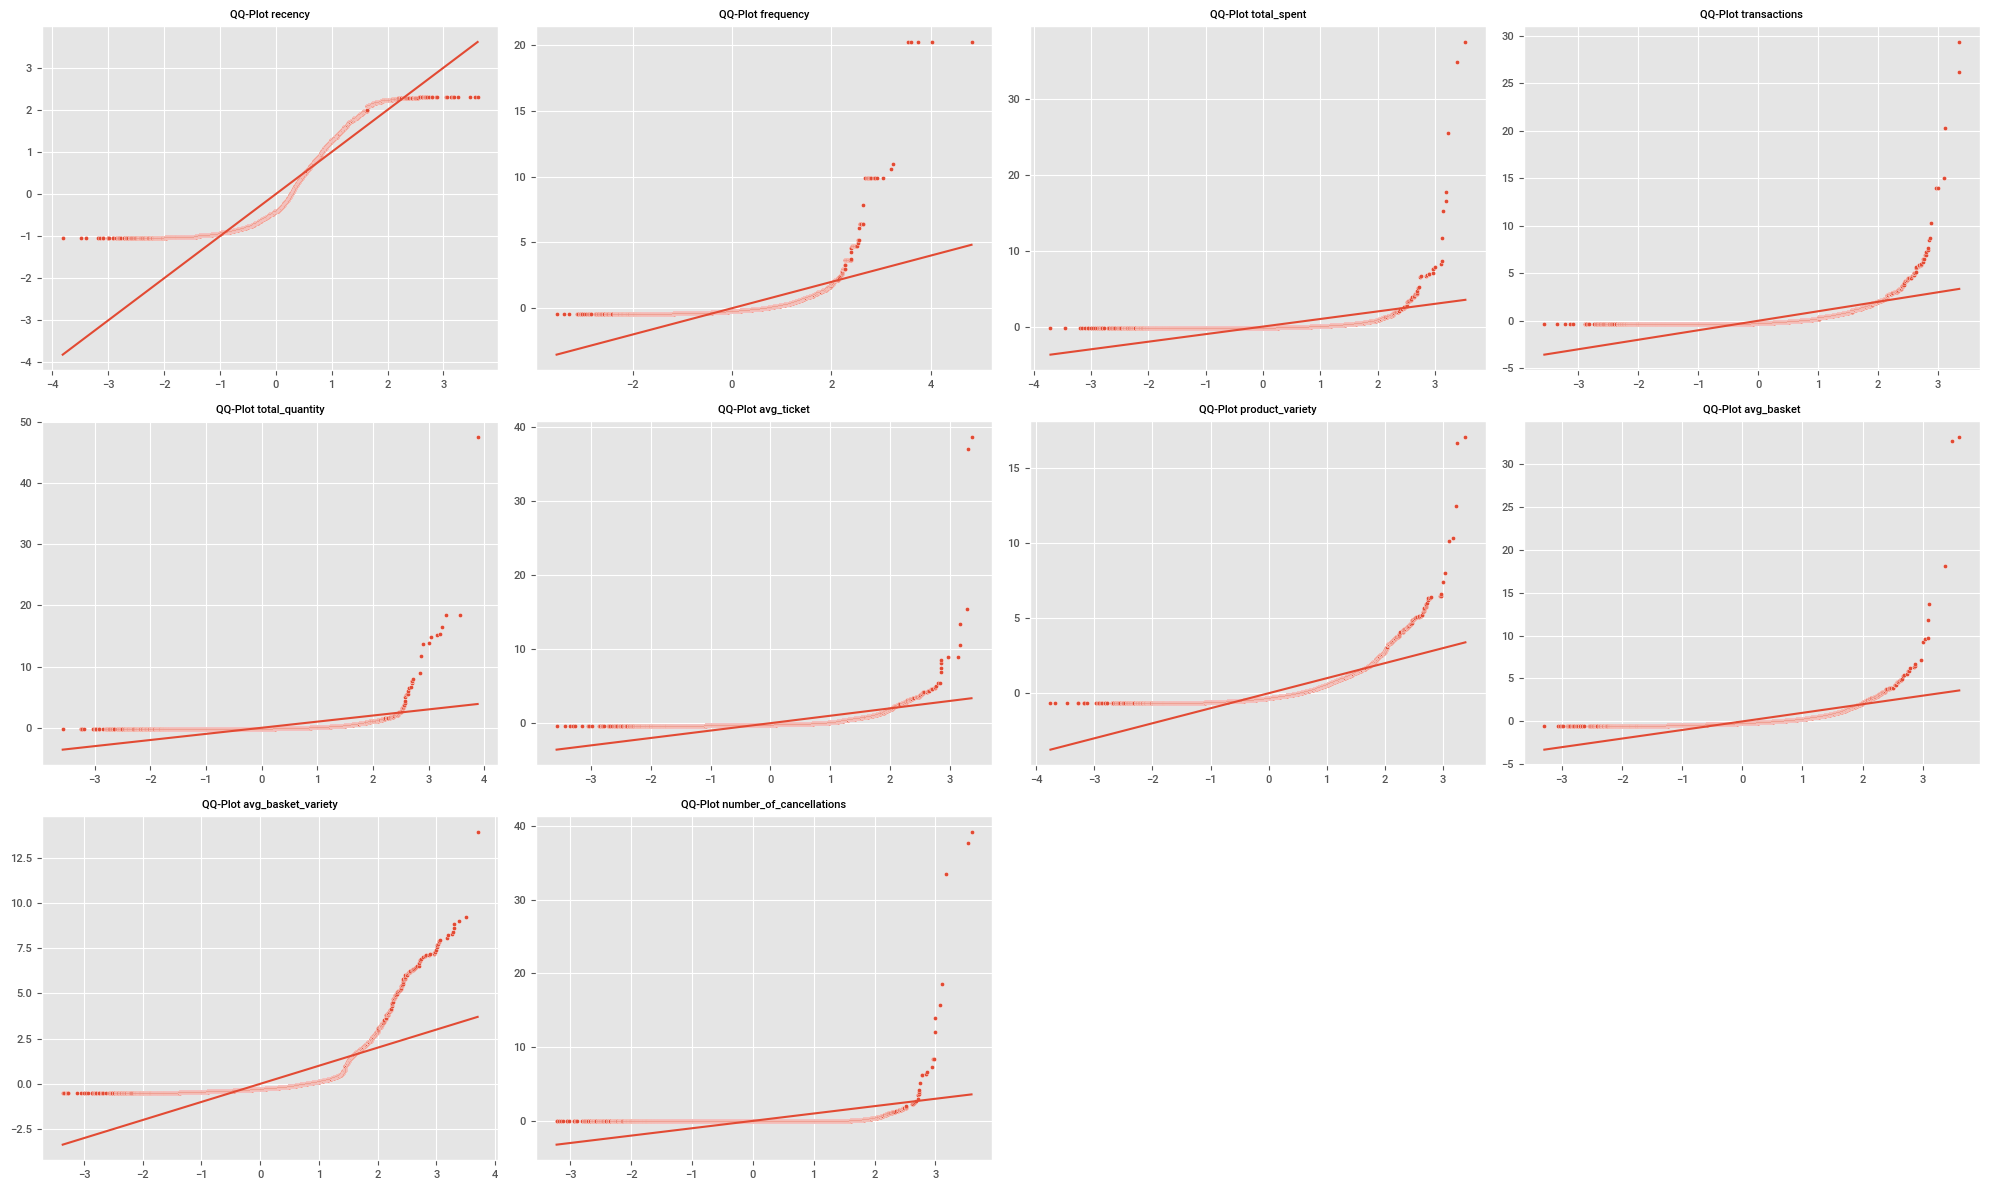

In [66]:
k = 1
columns = df_prep.drop(columns=['customer_id']).columns
n_plots = len(columns)
ncols = 4
nrows = int(np.ceil(n_plots/ncols))
plt.figure(figsize=(20, 12))
for feature in columns:

    plt.subplot(nrows, ncols, k)
    plt.title(f'QQ-Plot {feature}', fontsize=8)
    gu.qq_plot(feature, df_prep, std)
    plt.tight_layout()
    k += 1
    
    #print(k)

None of the features follows a normal distribution.

**Using Min Max Scaler for all features.**

In [67]:
#df_prep_scaled
df_prep_scaled = pd.DataFrame(preprocess.fit_transform(df_prep))
cols = np.concatenate((pass_cols, cols), axis=0)
df_prep_scaled.columns = cols

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 6.0. Feature Selection

Now, we will select the features that will make more sense in a business perspective when we analyze the clusters' metrics.

In [68]:
# avg_basket
# avg_recency
# items
# Transaction

columns_selected = ['customer_id', 'recency', 'frequency', 'total_spent', 'total_quantity', 'number_of_cancellations']

In [69]:
df_fselect = df_prep.copy()[columns_selected]
df_fselect_sc = df_prep_scaled.copy()[columns_selected]

# 7.0. Embedding Spaces

In this Section, we will visualize the data in a lower dimensional space with tree different dimensionality reduction techniques:

Principal Component Analysis (PCA)

t-Distributed Stochastic Neighbor

UMAP (Uniform Manifold Approximation and Projection)

Tree-based embedding and UMAP for dimensionality reduction.

In [70]:
df_embed = df_fselect.drop(columns=['customer_id']).copy()

df_embed_sc = df_fselect_sc.drop(columns=['customer_id']).copy()

## 7.1. PCA

This method consits of rotating the dataset in a way such that the rotated features (principal components) are statiscally uncorrelated. Then a subset of the new features are selected according to their importance to explain the data.

obs: PCA aligns the principal components with the directions of maximum variance in the original data.

In [76]:
pca = PCA(n_components=df_embed_sc.shape[1])
pca.fit(df_embed_sc)
df_pca = pca.transform(df_embed_sc)
print(f'Original shape: {str(df_embed_sc.shape)}')
print(f'Reduced shape: {str(df_pca.shape)}')
print(f'{sum(pca.explained_variance_ratio_):.3f}')

Original shape: (5680, 5)
Reduced shape: (5680, 5)
1.000


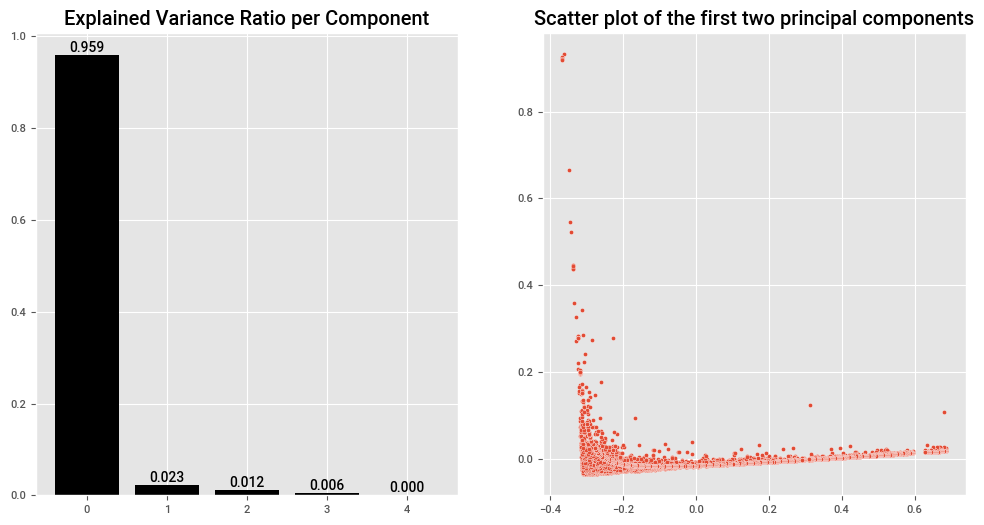

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x_pos = np.arange(pca.n_components_)
bar = ax[0].bar(x=x_pos, height=pca.explained_variance_ratio_, color='k')
ax[0].set_title('Explained Variance Ratio per Component')

ax[0].bar_label(bar, fmt='%.3f');


sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], ax=ax[1])
plt.title('Scatter plot of the first two principal components')
plt.show()


## 7.2. T-SNE

This is a dimensionality reduction technique that is most commonly used for visualizing high-dimensional data in a lower-dimensional space 2D or 3D.

obs:

    - t-SNE adapts its notion of 'distance' to regional density variations in the data, so you cannot see relative sizes of clusters in a t-SNE plot. So be careful when analyzing the t-sne results and clustering on it.
    
    - We might need to fine-tune some of the hyperparameters.

    https://distill.pub/2016/misread-tsne/

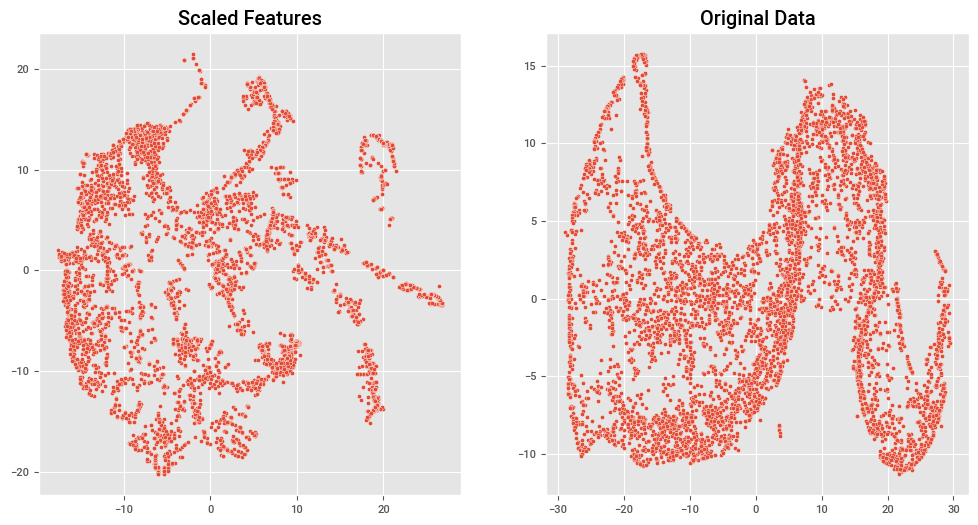

In [78]:
tsne = man.TSNE(perplexity=40, n_iter=1500, random_state=42, n_components=3)

df_tsne_sc = tsne.fit_transform(df_embed_sc)
df_tsne = tsne.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_tsne_sc[:, 0], y=df_tsne_sc[:, 1])
plt.title('Scaled Features')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1])
plt.title('Original Data')
plt.show()

## 7.3. UMAP

It is a dimension reduction technique constructed from a theoretical framework based in Riemannian geometry and algebraic topology. It can be used for visualization similarly to t-SNE.

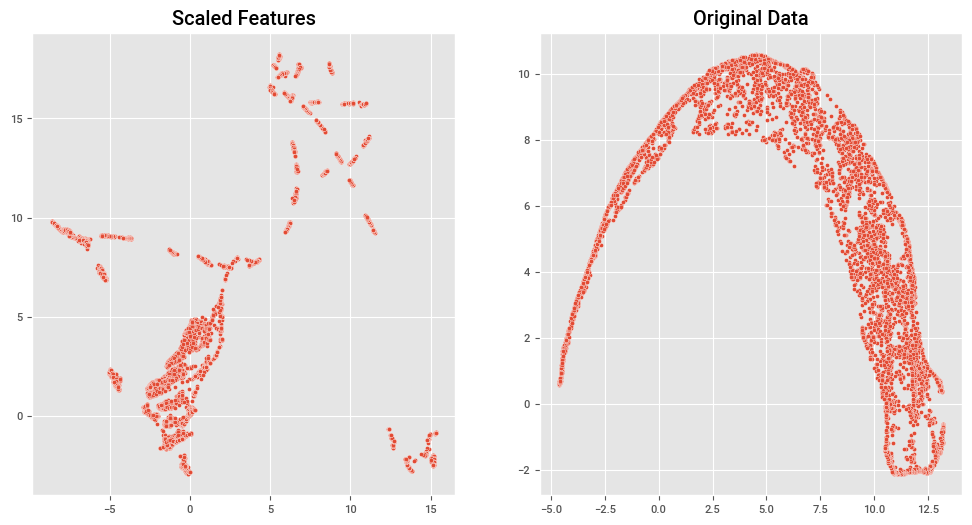

In [79]:
umap = um.UMAP(n_neighbors=40, random_state=42, n_components=3, n_epochs=500)

df_umap_sc = umap.fit_transform(df_embed_sc)
df_umap = umap.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_umap_sc[:, 0], y=df_umap_sc[:, 1])
plt.title('Scaled Features')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1])
plt.title('Original Data')
plt.show()


## 7.4. Tree-Based Embedding

In this section, we will create a tree-based space using the total spent as the target variable and then use the UMAP dimension reduction method. To make this tree-based space, I used the ´apply´ method that returns the leaf indices from each tree, resulting in a data frame with n columns, where n is the number of estimators in the random forest.

With this technique, we lose explainability about how the clusters are formed, but it might help the model find them. And for this project, we are not interested in explaining why a customer belongs or not to a specific group.

In [71]:
X = df_embed.drop(columns='total_spent')
y = df_embed['total_spent']

# model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# training
rf.fit(X, y)

# Aplying the tree structure in the training set (Leafs)
df_leaf = pd.DataFrame(rf.apply(X)) 

#pickle.dump(rf, open('../models/rf_model.pkl', 'wb'))

In [72]:
#fs = s3fs.S3FileSystem(anon=False, key=key, secret=secret)
#pickle.dump(rf, fs.open('s3://insider-data-bucket/rf_model.pkl', 'wb'))

<AxesSubplot: >

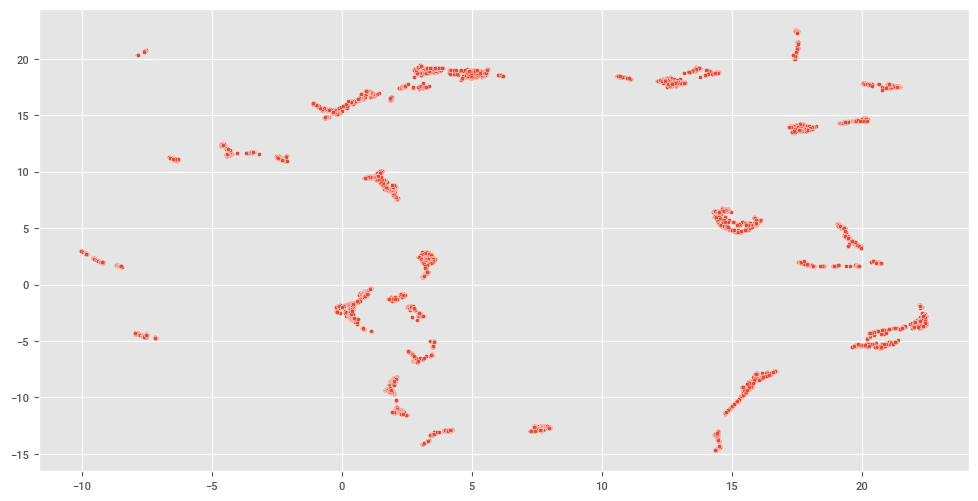

In [73]:
umap = um.UMAP(n_neighbors=50, random_state=42, n_jobs=-1, n_components=2, n_epochs=500)

trans = umap.fit(df_leaf)
df_umap_rf = trans.transform(df_leaf)

df_embed_tree = pd.DataFrame(df_umap_rf)
plt.figure(figsize=(12, 6))

sns.scatterplot(x=df_umap_rf[:, 0], y=df_umap_rf[:, 1])


In [89]:
#px.scatter_3d(x=df_umap_rf[:, 0], y=df_umap_rf[:, 1], z=df_umap_rf[:, 2])

In [90]:
#pickle.dump(trans, open('../models/umap_reducer.pkl', 'wb'))
#pickle.dump(umap, fs.open('s3://insider-data-bucket/umap_reducer.pkl', 'wb'))

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Hyperparameter Fine-Tuning

In this section, we assess three models — k-means, Gaussian mixture and hierarchical clustering — using the silhouette score. For each model, we experiment multiple values of k (number of clusters) accross four different spaces: feature space, T-sne embedding, UMAP embedding, and tree-based embedding. We generate corresponding plots to visualize the results.

In [80]:
#X = df_fselect_sc.copy().reset_index(drop=True).drop(columns=['customer_id'])
# Using the data of the embedding space build with umap and a tree model

X = df_embed_sc.copy()

X_tree = df_embed_tree.copy()

X_umap = df_umap_sc.copy()

X_tsne = df_tsne_sc.copy()

## 8.1. K-Means

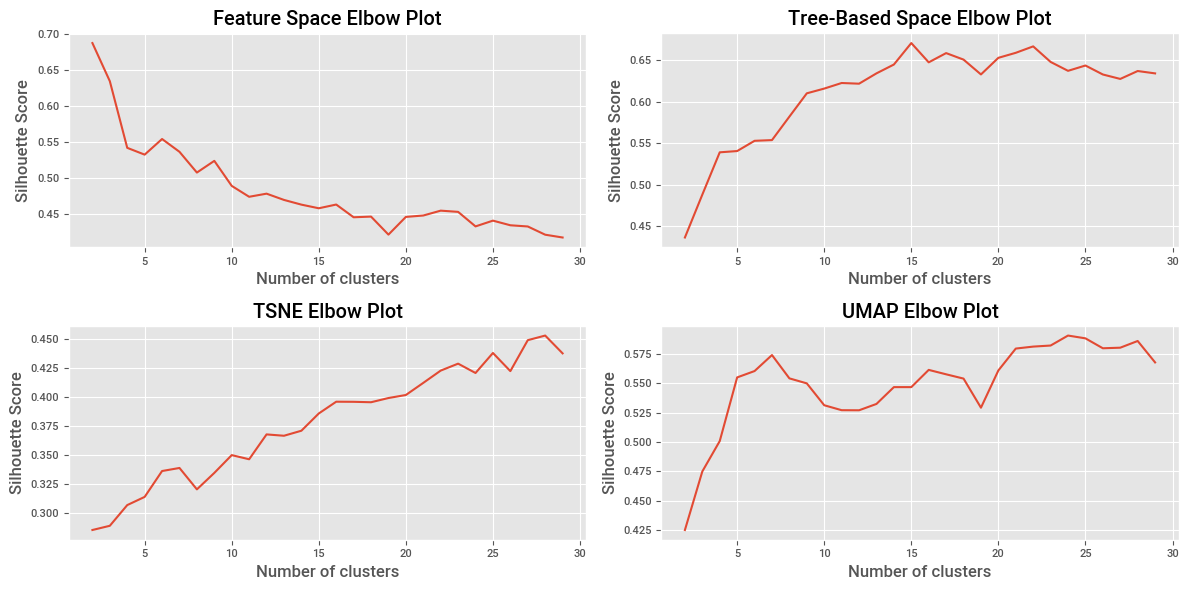

In [92]:
clusters = np.arange(2, 30, 1)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
gu.kmeans_performance(X=X, title='Feature Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 2)
gu.kmeans_performance(X=X_tree, title='Tree-Based Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 3)
gu.kmeans_performance(X=X_tsne, title='TSNE', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 4)
gu.kmeans_performance(X=X_umap, title='UMAP', clusters=clusters, metric='euclidean')
plt.tight_layout()

## 8.2 GMM

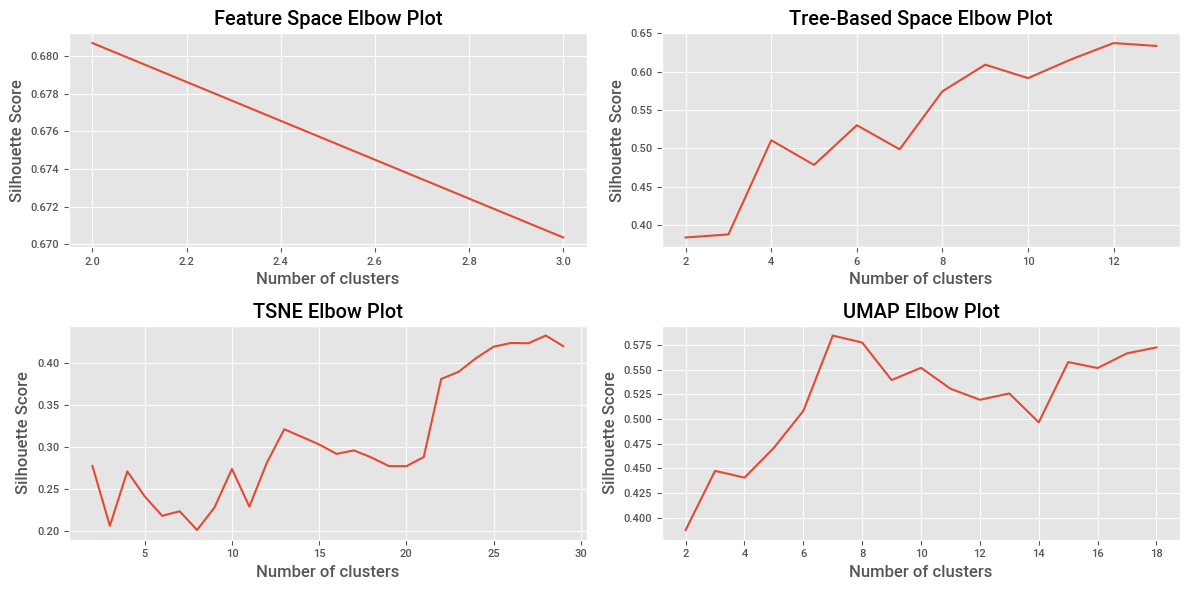

In [93]:
clusters = np.arange(2, 30, 1)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
gu.gmm_performance(X=X, title='Feature Space', components=clusters, metric='euclidean', covariance_type='tied')
plt.subplot(2, 2, 2)
gu.gmm_performance(X=X_tree, title='Tree-Based Space', components=clusters, metric='euclidean', covariance_type='tied')
plt.subplot(2, 2, 3)
gu.gmm_performance(X=X_tsne, title='TSNE', components=clusters, metric='euclidean', covariance_type='tied')
plt.subplot(2, 2, 4)
gu.gmm_performance(X=X_umap, title='UMAP', components=clusters, metric='euclidean', covariance_type='tied')
plt.tight_layout()

## 8.3 Hierarchical Custering

In [94]:
hc_model = linkage(X, 'ward')
dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.plot()

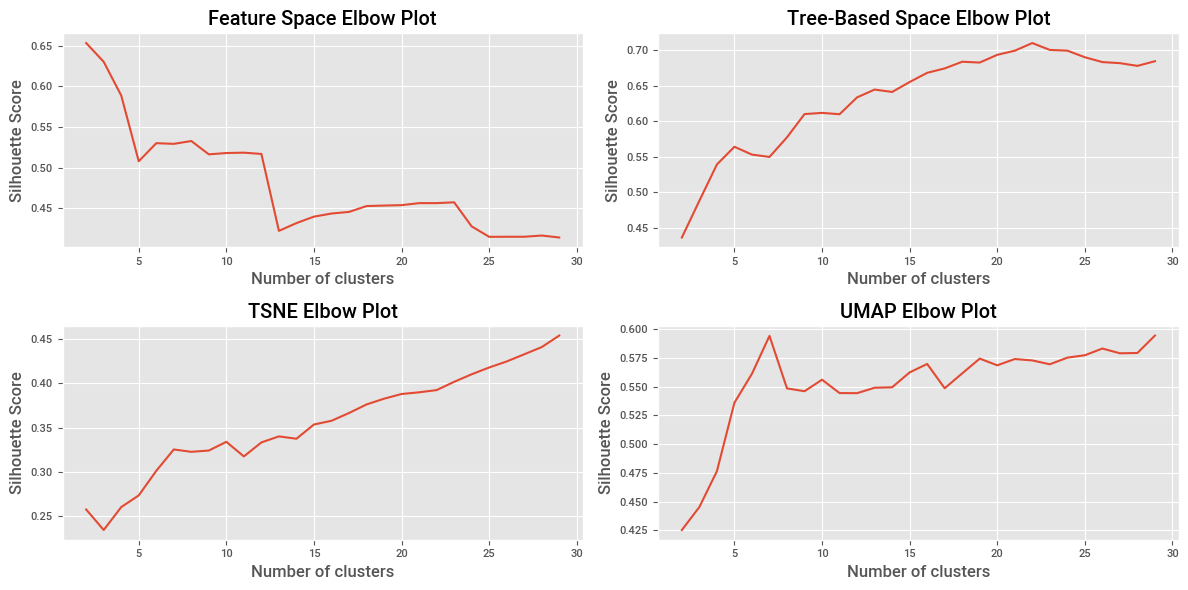

In [96]:
clusters = np.arange(2, 30, 1)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
gu.hierarchical_performance(X=X, title='Feature Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 2)
gu.hierarchical_performance(X=X_tree, title='Tree-Based Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 3)
gu.hierarchical_performance(X=X_tsne, title='TSNE', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 4)
gu.hierarchical_performance(X=X_umap, title='UMAP', clusters=clusters, metric='euclidean')
plt.tight_layout()

The tree-based space consistently produced the highest silhoutte scores for every model.

# Results

In [97]:
hierarch_perf = gu.hierarchical_performance(X=X_tree, clusters=clusters, plot=False, metric='euclidean')
gmm_perf = gu.gmm_performance(X=X_tree, components=clusters, plot=False, metric='euclidean', covariance_type='tied')
kmeans_perf = gu.kmeans_performance(X=X_tree, clusters=clusters, plot=False, metric='euclidean')

results = pd.concat([kmeans_perf, hierarch_perf, gmm_perf])
results.columns = clusters

results.style.highlight_max(color='lightgreen', axis=1)

## Silhouette Analysis

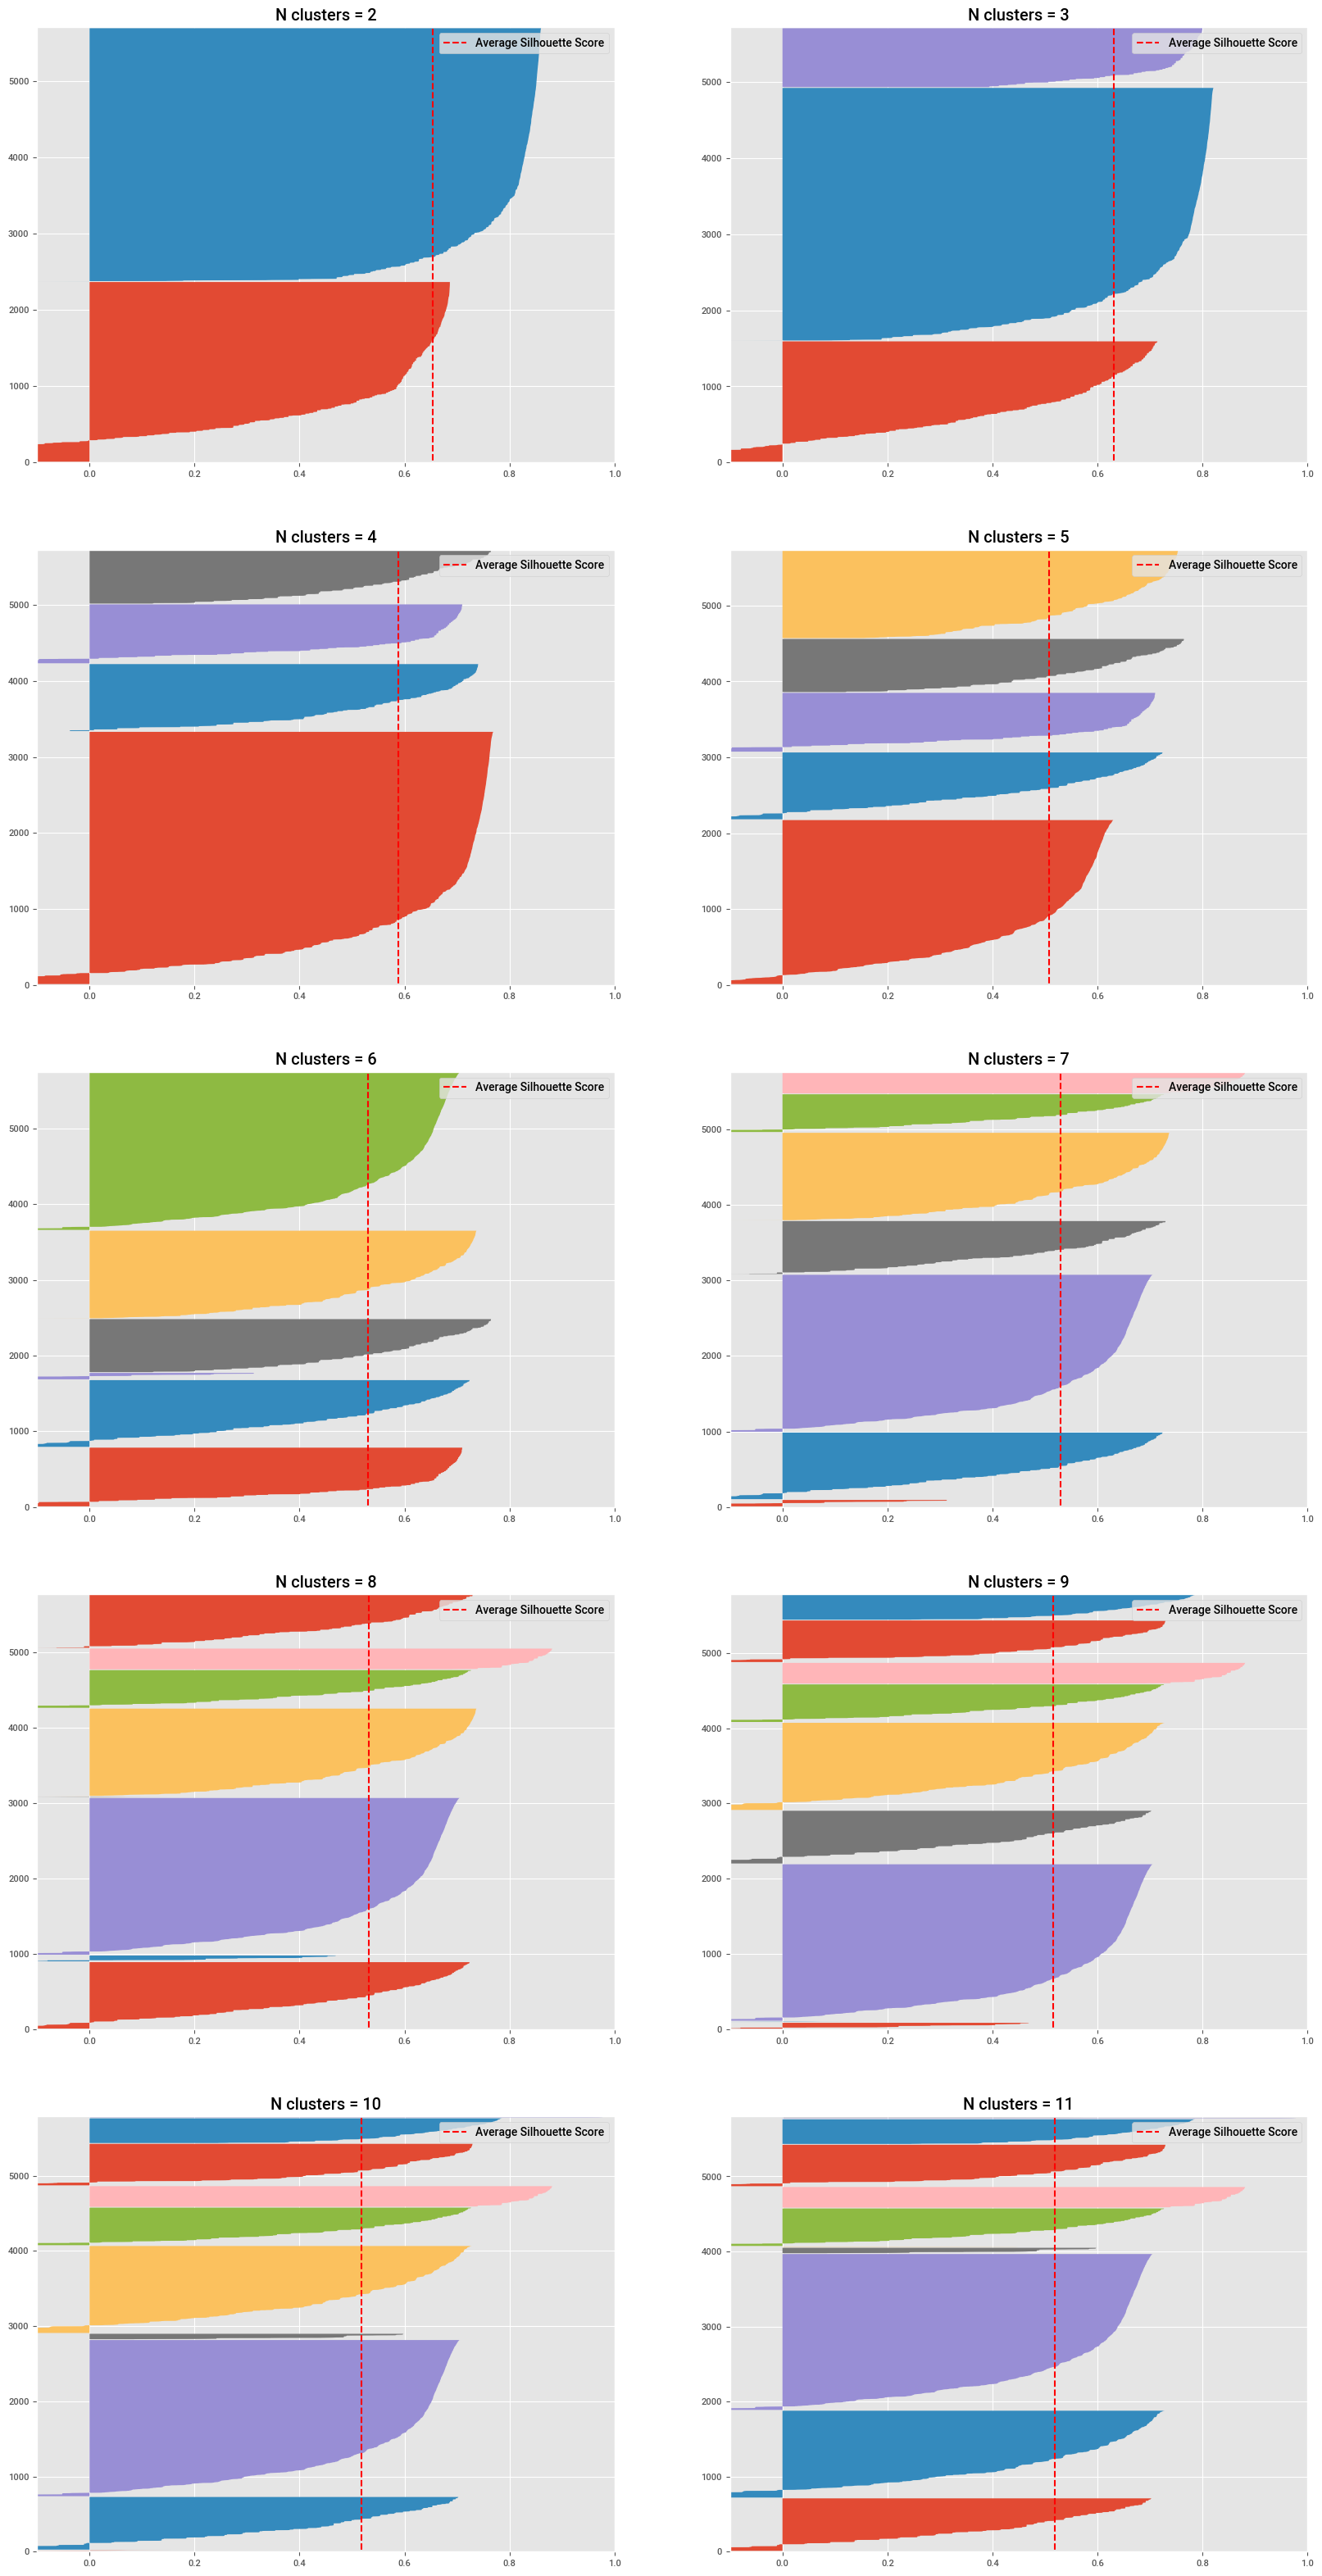

In [98]:
fig, ax = plt.subplots(5, 2, figsize=(20, 40))
n_clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11,]
for k in n_clusters:

    # model
    agg_clu = AgglomerativeClustering(n_clusters=k)
    labels = agg_clu.fit_predict(X)

    q, mod = divmod(k, 2)

    gu.silhouette_analysis(X, labels, ax=ax[q-1, mod], k=k)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Model Training

## 8.1. Hierarchical Clustering

In [81]:
n_cluster = 10
kmeans = KMeans(init='random', n_clusters=n_cluster, n_init=10, max_iter=300, random_state=42 )

labels = kmeans.fit_predict(X_tree)

sil = mt.silhouette_score(X_tree, labels, metric='euclidean')

print(f'Silhouette Score: {sil}')

Silhouette Score: 0.6161004900932312


I iterated through this process multiple times to determine the appropriate algorithm and the number of clusters. I aimed to avoid having too many groups since it would be difficult to manage. 

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 9.0. Cluster Analysis

## 9.1. Visualization

In [82]:
cluster_df = df_fselect.copy()
cluster_df_sc = df_fselect_sc.copy()
cluster_df['cluster'] = labels
cluster_df_sc['cluster'] = labels

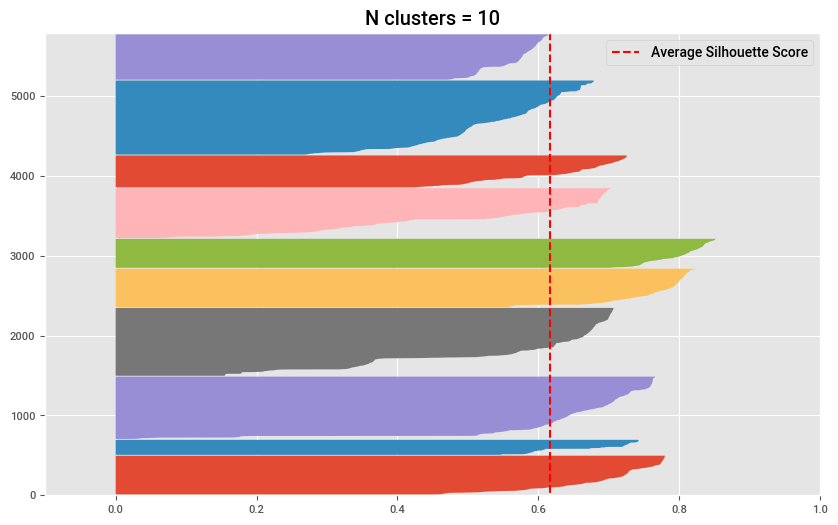

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gu.silhouette_analysis(X_tree, labels, ax, n_cluster)

In [84]:
fig = px.scatter_matrix(cluster_df_sc.drop(columns=['customer_id']), color='cluster')
fig.update_layout(width=1800, height=980, font={'size': 9})
fig.show()

e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



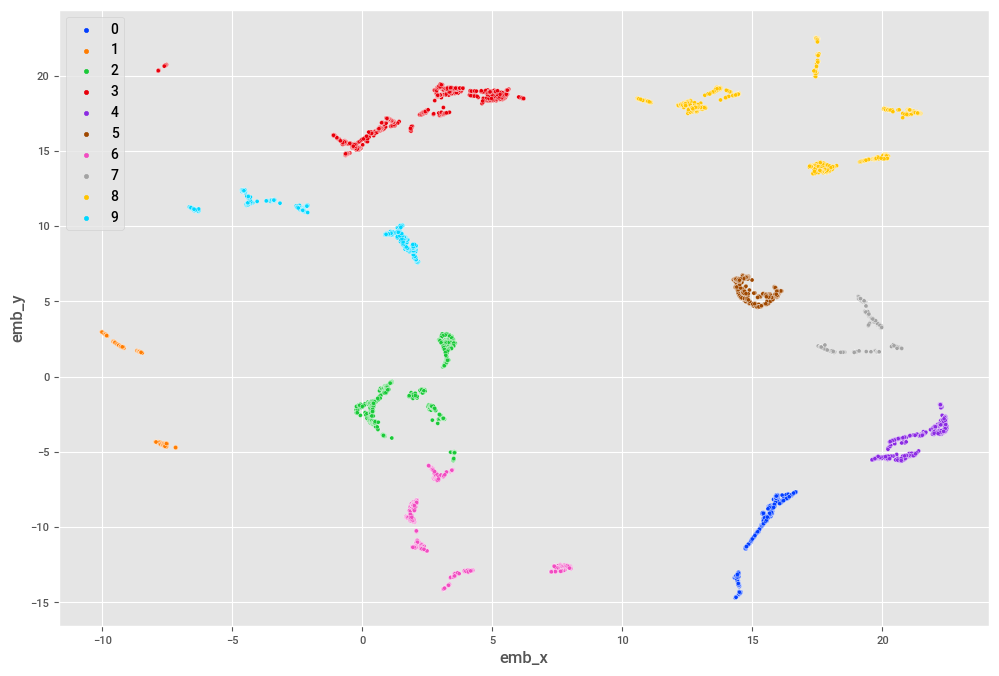

In [85]:
df_aux = df_embed_tree
df_aux.rename(columns={0: 'emb_x', 1: 'emb_y', 2: 'emb_z'}, inplace=True)
df_aux['cluster'] = labels
plt.figure(figsize=(12, 8))
sns.scatterplot(x='emb_x', y='emb_y', hue='cluster', data=df_aux, palette='bright')
plt.legend(loc='upper left')
plt.show()

In [86]:
#df_aux['cluster'] = df_aux['cluster'].astype('object')
#px.scatter_3d(x='emb_x', y='emb_y', z='emb_z', data_frame=df_aux, color='cluster')

## 9.2. Clusters Profile

In [87]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index().rename(columns={'customer_id': 'number_of_customers'})
prof['percentual'] = round((cluster_df.groupby('cluster').count().reset_index()['customer_id']/cluster_df.shape[0])*100, 2)

prof['avg_recency'] = cluster_df.groupby('cluster').mean().reset_index()['recency']

prof['avg_frequency'] = cluster_df.groupby('cluster').mean().reset_index()['frequency']

prof['avg_spent'] = cluster_df.groupby('cluster').mean().reset_index()['total_spent']

prof['number_of_cancellations'] = cluster_df.groupby('cluster').mean().reset_index()['number_of_cancellations']

prof['avg_quantity'] = cluster_df.groupby('cluster').mean().reset_index()['total_quantity']


prof
prof.style.highlight_max(axis=0, subset=['avg_frequency',	'avg_spent', 'avg_quantity']).highlight_min(subset=['avg_recency', 'number_of_cancellations'], axis=0)

I can't say the reason why the customers were grouped because they have similar attributes because the clusters were formed in an embedding space.

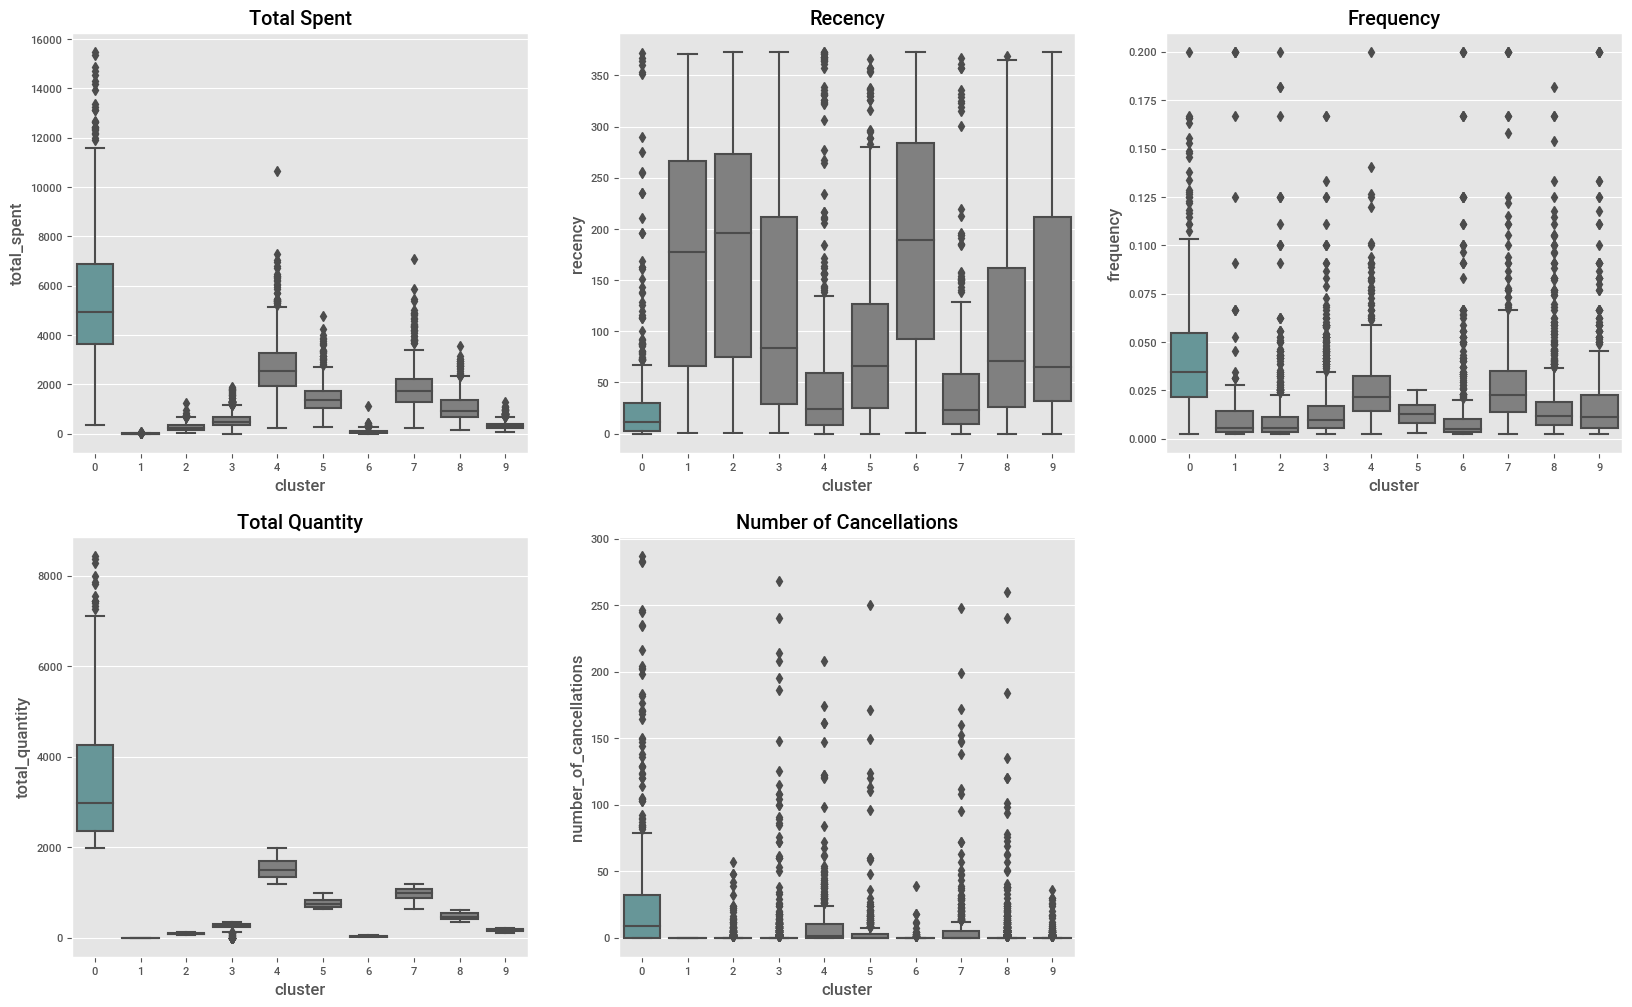

In [88]:
colors = ['cadetblue', 'grey', 'grey',  'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.title('Total Spent')
sns.boxplot(x='cluster', y='total_spent', data=cluster_df.loc[cluster_df.total_spent <= np.quantile(cluster_df.total_spent, 0.99)], palette=colors)
plt.subplot(2, 3, 2)
plt.title('Recency')
sns.boxplot(x='cluster', y='recency', data=cluster_df, palette=colors)
plt.subplot(2, 3, 3)
plt.title('Frequency')
sns.boxplot(x='cluster', y='frequency', data=cluster_df.loc[cluster_df.frequency <= np.quantile(cluster_df.frequency, 0.99)], palette=colors)


plt.subplot(2, 3, 4)
plt.title('Total Quantity')
sns.boxplot(x='cluster', y='total_quantity', data=cluster_df.loc[cluster_df.total_quantity <= np.quantile(cluster_df.total_quantity, 0.99)], palette=colors)

plt.subplot(2, 3, 5)
plt.title('Number of Cancellations')
sns.boxplot(x='cluster', y='number_of_cancellations', data=cluster_df.loc[cluster_df.number_of_cancellations <= np.quantile(cluster_df.number_of_cancellations, 0.99)], palette=colors);

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 10.0. Exploratory Data Analysis

## 10.1. Hypothesis MindMap

<img src="../images/mind_map.png">

## 10.2. Business Hypothesis 

### Purchases

<s>1. The customers in the insider group use a credit card as the paymennt method in 80% of their purchases.</s>

2. 60% of customers in the insider group have a a higher variety of products in their purchase history than the general average.

3. The average ticket of the insider group is 50% higher than the other groups.

4. 50% of the insiders have a frequency higher than 0.1.

5. The customers in the insider group have a basket size bigger than 5 products.

**6. The volume of purchases of the insider group represents 15% of the overall volume.**

**7. The insider group of customers has a purchase cancellation rate that is 5% lower than the overall cancellation rate..**


<s>8. 5% of the customers in the insider group receive more than U$ 100,000.00 annually.

### Product

<s>1. The customers in the insider group buy products with an above average price.</s>

2. 70% of the customers in the worst group buy products with a unit price lower than the overall average.

3. 30% of the products sold in big packages, of the whole dataset, are bought by customers in the insider group.** 

**4. The median price of the products bought by the customers in the insider group is 10% higher than the overall median.**

<s>5. The average weight of the products bought by the insider group is higher than the average weight product bought by the other clusters.</s>

### Customers

<s>1. The customers of the insider group are, o average, older than the customer of the other groups.</s>

<s>2. 60% of the insiders are at least undergraduates.</s>

<s>3. The top 100 highest spenders have a family with at least 4 members.</s>

<s>4. The insider group is composed of 60% of women.</s>

<s>5. The top 30 highest buyers of the insiders group live nearby the headquarters of the e-commerce.</s>

<s>6. 80% of the customers in the insider group are single.</s>

<s>7. 10% of the customer in the insider group are in the age range of 24-35 years.</s>

<s>8. 40% of the delivery address are in a radius of 50 km.

## 10.3. Hypothesis Validation

**H0:** The volume of purchases (quantity) made by the insider group of customers represents 15% or more of the overall volume of purchases.

The insider group is responsible for 57.91% of the quantities sold.


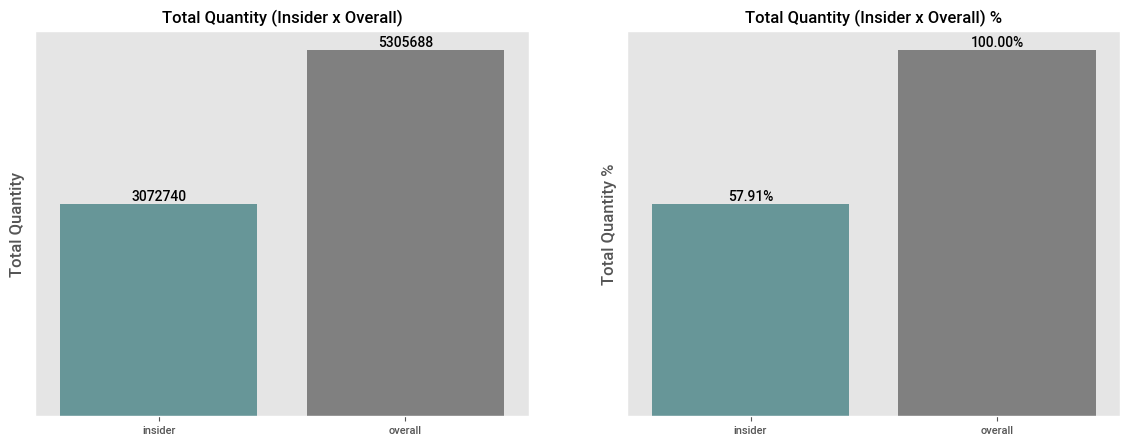

In [89]:
insider = cluster_df.query('cluster==0').total_quantity.sum()
overall = cluster_df.total_quantity.sum()

insider_perc = round(insider/overall, 4)*100
overall_perc = 1*100

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Total Quantity (Insider x Overall)', fontsize=12)
bar1 = sns.barplot(y=[insider, overall], x=['insider', 'overall'], palette=['cadetblue', 'grey'])
plt.bar_label(bar1.containers[0], fmt="%d")
plt.ylabel('Total Quantity')
bar1.axes.set_yticks([])

plt.subplot(1, 2, 2)
plt.title('Total Quantity (Insider x Overall) %', fontsize=12)
bar2 = sns.barplot(y=[insider_perc, overall_perc], x=['insider', 'overall'], palette=['cadetblue', 'grey']);
plt.bar_label(bar2.containers[0], fmt='%.2f%%')
bar2.axes.set_yticks([])
plt.ylabel('Total Quantity %')

print(f'The insider group is responsible for {insider_perc}% of the quantities sold.')

**H1:** The average total spent by the customers of the insider group is 50% higher than the average total spent by customers in other groups.

In [90]:
df_aux = cluster_df.copy()
df_aux['group'] = df_aux['cluster'].apply(lambda x: 'insider' if x == 0 else 'other')
df_aux = df_aux.groupby('group').mean().total_spent.reset_index()
per = round(((df_aux.iloc[0][1] - df_aux.iloc[1][1])/df_aux.iloc[1][1]), 4)

The Average total spent of the insider group is 1112.11% higher than the average of the other groups


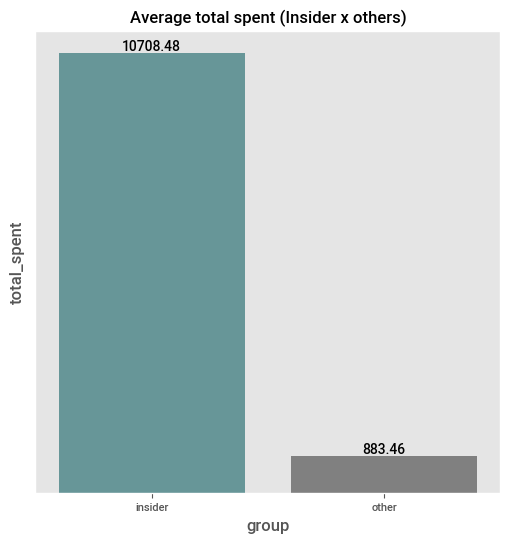

In [91]:
plt.figure(figsize=(6, 6))
bar = sns.barplot(x='group', y='total_spent', data=df_aux, palette=['cadetblue', 'grey'])
print(f'The Average total spent of the insider group is {per:.2%} higher than the average of the other groups')
plt.title('Average total spent (Insider x others)', fontsize=12)
bar.axes.set_yticks([])
plt.bar_label(bar.containers[0], fmt='%.2f');

**H2:** The revenue generated by the insider group of customers represents 15% or more of the total revenue.

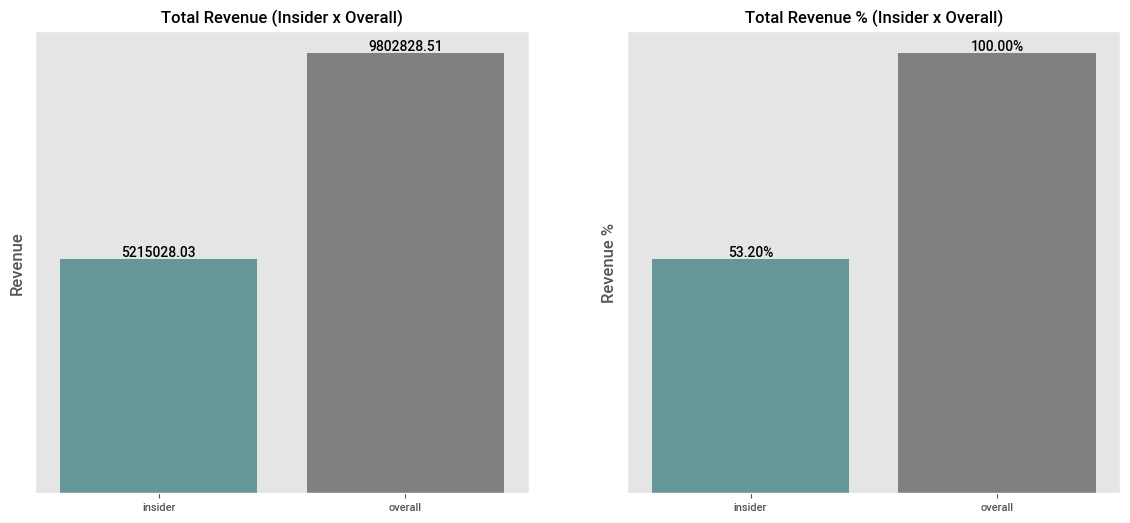

In [92]:
insider = cluster_df.query('cluster==0').total_spent.sum()
overall = cluster_df.total_spent.sum()

insider_perc = round(insider/overall, 4)
overall_perc = 1

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('Total Revenue (Insider x Overall)', fontsize=12)
bar1 = sns.barplot(y=[insider, overall], x=['insider', 'overall'], palette=['cadetblue', 'grey'])
bar1.axes.set_yticks([])
plt.ylabel('Revenue')
plt.bar_label(bar1.containers[0], fmt='%.2f')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Total Revenue % (Insider x Overall)', fontsize=12)
bar2 = sns.barplot(y=[insider_perc*100, overall_perc*100], x=['insider', 'overall'], palette=['cadetblue', 'grey']);
bar2.axes.set_yticks([])
plt.ylabel('Revenue %')
plt.bar_label(bar2.containers[0], fmt='%.2f%%');
plt.grid(False)

In [93]:
print(f'TRUE: The insider group is responsible for {insider_perc:.2%} of the sales.')

TRUE: The insider group is responsible for 53.20% of the sales.


**H3:** The insider group of customers has a purchase cancellation rate that is 5% lower than the overall cancellation rate.

The insider group cancellation rate is -41.78% lower than the overall average.


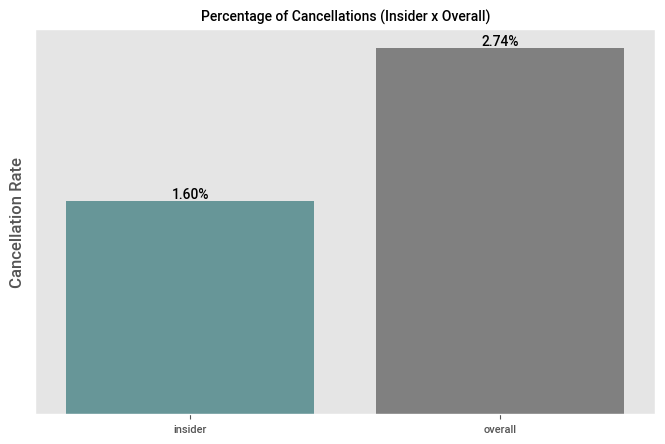

In [94]:
df_canc_by_quantity = cluster_df.copy()
df_canc_by_quantity['cancellation_by_quantity'] = df_canc_by_quantity.number_of_cancellations/df_canc_by_quantity.total_quantity
insider = df_canc_by_quantity.query('cluster==5').groupby('cluster').mean().cancellation_by_quantity[5]

overall = df_canc_by_quantity.mean().cancellation_by_quantity
perc = (insider - overall)/overall

plt.figure(figsize=(8, 5))
plt.title('Percentage of Cancellations (Insider x Overall)', fontsize=10)
bar = sns.barplot(y=[insider*100, overall*100], x=['insider', 'overall'], palette=['cadetblue', 'grey'])
bar.axes.set_yticks([])
plt.bar_label(bar.containers[0], fmt='%.2f%%')
plt.ylabel('Cancellation Rate');

print(f'The insider group cancellation rate is {perc:.2%} lower than the overall average.')


In [116]:
#insider = cluster_df.query('cluster==0').groupby('cluster').mean().number_of_cancellations[0]
#
#overall = cluster_df.mean().number_of_cancellations
#perc = (insider - overall)/overall
#
#plt.figure(figsize=(8, 5))
#plt.title('Number of Cancellations (Isinder x Overall)', fontsize=10)
#bar = sns.barplot(y=[insider, overall], x=['insider', 'overall'], palette=['cadetblue', 'grey'])
#bar.axes.set_yticks([])
#plt.bar_label(bar.containers[0], fmt='%d')
#plt.ylabel('Cancellations')
#print(f'The average number of cancelations made by the insider group is {perc:.2%} higher than the overall average.')

**H04:** The median total spent by the group insider is 30% higher than the overall median.

In [95]:
median_insider = cluster_df.query('cluster == 0').total_spent.median()
overall_median = cluster_df.total_spent.median()

perc_diff = (median_insider - overall_median)/overall_median

print(f'The median total spent of the group insider is {perc_diff:.2%} higher than the overall median.')

The median total spent of the group insider is 786.26% higher than the overall median.


**H05:** The customers in the insider group are concentrated in the 3° quantile of the monetary feature.

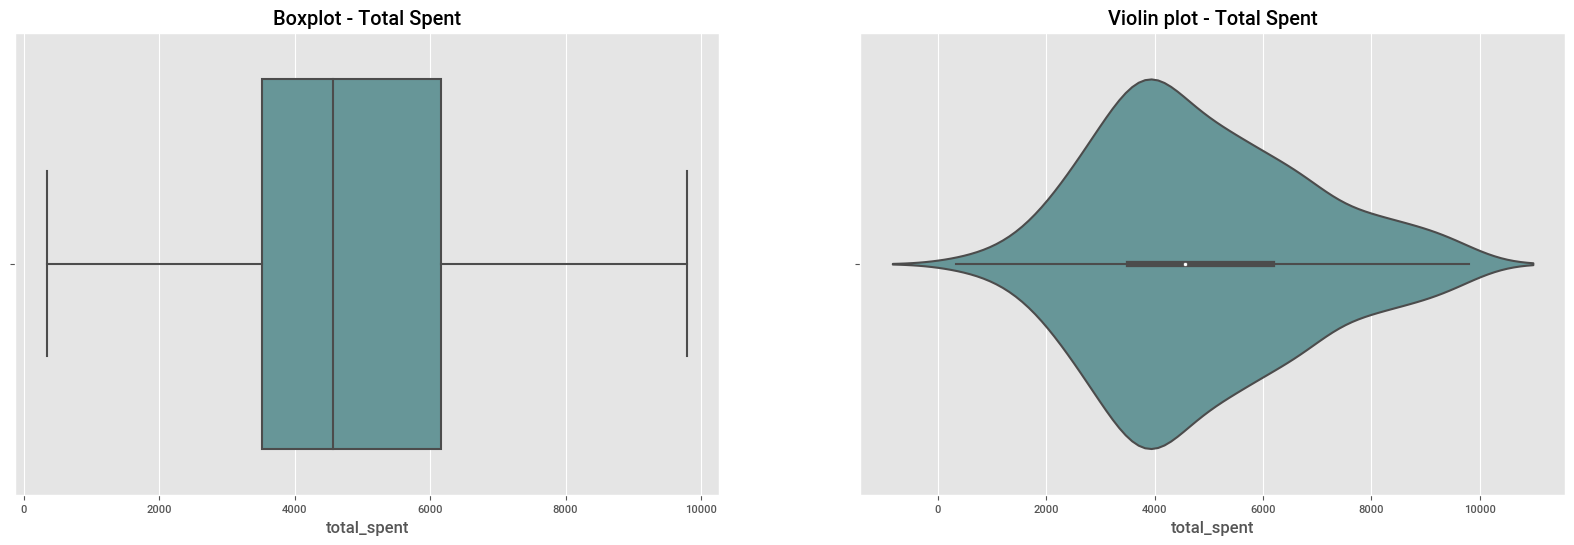

In [96]:
monetary = cluster_df.query('cluster == 0 & total_spent < 10000').total_spent

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=monetary, color='cadetblue')
plt.title('Boxplot - Total Spent')

plt.subplot(1, 2, 2)
sns.violinplot(x=monetary, color='cadetblue')
plt.title('Violin plot - Total Spent');

The customers in the insider group are concentrated in the first quantile.

## Business Questions

### 1. Who are the customers eligible for the insider cluster?

In [99]:
insider_ids = cluster_df.query('cluster == 0')[['customer_id']]
insider_ids.head(8)

customer_id
2         12583
5         15291
6         14688
7         17809
8         15311
12        16029
14        12431
15        17511

In [100]:
#with open('../reports/table.md', 'w') as file:
#    file.write(insider_ids.to_markdown())
    

### 2. How many customers will be in the group?

In [ ]:
number_of_customers = cluster_df.query('cluster == 0')[['customer_id']].shape[0]

print(f'The insider group will have {number_of_customers} customers.')

The insider group will have 487 customers.


### 3. What are the main attributes of the customers in the insider group?

In [125]:
insiders = cluster_df.query('cluster == 0').drop(['customer_id'], axis=1)
insiders_car = insiders.groupby('cluster').mean().T.rename(columns={5: 'Average'})
conf_intervals = {}
for col in insiders.drop('cluster', axis=1).columns:

    conf_interval = st.t.interval(confidence=0.95,
                df=len(insiders)-1,
                loc=np.mean(insiders[col]),
                scale=st.sem(insiders[col]))
    
    conf_intervals[col] = conf_interval
    
insiders_car = pd.concat([insiders_car, pd.DataFrame(conf_intervals).T], axis=1) .rename(columns={0: 'LowerLimit', 1: 'UpperLimit'})

In [126]:
insiders_car

LowerLimit   LowerLimit    UpperLimit
recency                     30.172485    25.223354     35.121615
frequency                    0.052795     0.045459      0.060132
total_spent              10708.476448  8651.853310  12765.099585
total_quantity            6309.527721  5167.639018   7451.416423
number_of_cancellations    162.745380    92.300627    233.190133

In [117]:
#insiders = cluster_df.query('cluster == 0').drop(['customer_id'], axis=1)
#insiders_car = insiders.groupby('cluster').median().T.rename(columns={5: 'Median'})
#conf_intervals = {}
#
#for col in insiders.drop('cluster', axis=1).columns:
#
#    conf_interval = st.bootstrap((insiders[col], ), statistic=np.median, n_resamples=len(insiders), method='basic').confidence_interval
#    
#    conf_intervals[col] = conf_interval
#    
#insiders_car = pd.concat([insiders_car, pd.DataFrame(conf_intervals).T], axis=1) .rename(columns={0: 'LowerLimit', 1: 'UpperLimit'})
#insiders_car

### 4. What is the share of the revenue that comes from the Insider group? 


In [128]:
insider = cluster_df.query('cluster==0').total_spent.sum()
overall = cluster_df.total_spent.sum()

insider_perc = round(insider/overall, 4)
overall_perc = 1
print(f'The insider group is reponsable for {insider_perc:.2%} of the revenue.')

The insider group is reponsable for 53.20% of the revenue.


### 5. What are the requirements for a customer to be eligible for the Insider group?

The model will decide who will be eligible for the insider group.

### 6. What guarantees that the Insider program is better than the rest of the database?


The metrics of the insider group is better than the other groups.

### 7. What can the marketing team do to augment the revenue?

1. Offer a direct line to the best customers, improving the communication (anouncing products/services and promoting sales).
2. Drop off unprofitable customers (customers who only buy the discounted line and avoid premium range).
3. Personalized offers for each group.
4. Optimize marketing channels, identify the most effective marketing channels for each group.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 11.0. Deploy to Production

In [153]:
# adding the date of the last update of the model.
cluster_df['last_training_time'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [154]:
import sqlite3
from sqlalchemy import create_engine

In [155]:
query_delete_table = 'DROP TABLE insiders'

con = sqlite3.connect('insiders_db.sqlite')
con.execute(query_delete_table)
con.commit()
con.close()

In [156]:
query_create_table_insiders = """
    CREATE TABLE insiders(
        customer_id                 INTEGER,
        recency                     INTEGER,
        frequency                   REAL,
        total_spent                 REAL,
        total_quantity              INTEGER,
        number_of_cancellations     INTEGER,
        cluster                     INTEGER,
        last_training_time          TEXT
    )"""


con = sqlite3.connect('insiders_db.sqlite')
con.execute(query_create_table_insiders)
con.commit()
con.close()

# Insert Data

In [157]:
engine = create_engine('sqlite:///insiders_db.sqlite')
cluster_df.to_sql('insiders', con=engine, if_exists='append', index=False)

5685

In [158]:
pd.read_sql('select * from insiders', con=engine)

customer_id  recency  frequency  total_spent  total_quantity  \
0           17850      372   0.090909      5288.63            1693   
1           13047       56   0.024064      3089.10            1355   
2           12583        2   0.040107      6629.34            4978   
3           13748       95   0.013369       948.25             439   
4           15100      333   0.008021       635.10              58   
...           ...      ...        ...          ...             ...   
5680        22706        1   0.500000      5699.00            1747   
5681        22707        0   1.000000      6756.06            2010   
5682        22708        0   1.000000      3217.20             654   
5683        22709        0   1.000000      3950.72             731   
5684        12713        0   1.000000       794.55             505   

      number_of_cancellations  cluster   last_training_time  
0                          40        5  2023-04-14 14:55:30  
1                          35        5  2023-04-14 14:55:30  
2                          50        2  2023-04-14 14:55:30  
3                           0        1  2023-04-14 14:55:30  
4                          22        7  2023-04-14 14:55:30  
...                       ...      ...                  ...  
5680                        0        5  2023-04-14 14:55:30  
5681                        0        2  2023-04-14 14:55:30  
5682                        0        6  2023-04-14 14:55:30  
5683                        0        6  2023-04-14 14:55:30  
5684                        0        8  2023-04-14 14:55:30  

[5685 rows x 8 columns]

In [ ]:
query = """SELECT * FROM insiders"""

df=pd.read_sql_query(query, engine)

In [ ]:
# Banco NA AWS
variables_env = dotenv.dotenv_values('../.env')

host = variables_env['HOST']
port = variables_env['PORT']
database =variables_env['DATABASE']
user=variables_env['USER']
pwd=variables_env['PASSWORD']

endpoint = f'postgresql://{user}:{pwd}@{host}/{database}:{port}'

engine = create_engine(endpoint)

con = engine.connect()
con.execute(query_create_table_insiders)

con.commit()

cluster_df.to_sql('insiders', con=con, if_exists='append', index=False)
con.close()
